In [1]:
%%bash
nrnivmodl

/usr/bin/xcrun
/Users/anatolii-sorokin/Documents/Projects/neuro-trafic
Mod files: "./h.mod" "./kadist.mod" "./kaprox.mod" "./kdrca1.mod" "./km.mod" "./na3n.mod" "./naxn.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created arm64/special


In [2]:
# Download NEURON: http://www.neuron.yale.edu/neuron/download
# Download PyNeuronToolbox: https://github.com/ahwillia/PyNeuron-Toolbox

from neuron import h
import numpy as np
import math
import pylab as plt
import scipy.linalg
from PyNeuronToolbox.record import ez_record,ez_convert
from PyNeuronToolbox.morphology import shapeplot,shapeplot_animate
from mpl_toolkits.mplot3d import Axes3D
from JSAnimation import IPython_display
from matplotlib import animation
from matplotlib.pyplot import cm
%matplotlib inline
np.random.seed(123456789)

DC = 10 # diffusion coeff [microns^2 s^-1]

# Load morphology and other stuff
# --> SegLists: soma[2], dend[74], dend_5[37], apic[42], axon[1]
# --> Files from Migliore & Migliore (2012)
# --> CA1 pyramidal neuron
h.load_file('stdrun.hoc')
h.xopen('ri06.hoc')
h.xopen('fixnseg.hoc')
h.xopen('5a_nogui.hoc')
h.tstop = 700.0

	0 
total # of segments (50Hz): 742   max path distance: 853.32493 
apical 0  dend_5[0]
apical 1  dend_5[15]
apical 2  dend_5[14]
apical 3  dend_5[13]
apical 4  dend_5[12]
apical 5  dend_5[12]
apical 6  dend_5[12]
apical 7  dend_5[12]
apical 8  dend_5[12]
apical 9  dend_5[12]
apical 10  dend_5[12]
apical 11  dend_5[11]
apical 12  dend_5[11]
apical 13  dend_5[11]
apical 14  dend_5[10]
apical 15  dend_5[9]
apical 16  dend_5[8]
apical 17  dend_5[8]
apical 18  dend_5[8]
apical 19  dend_5[7]
apical 20  dend_5[6]
apical 21  dend_5[5]
apical 22  dend_5[5]
apical 23  dend_5[5]
apical 24  dend_5[5]
apical 25  dend_5[5]
apical 26  dend_5[5]
apical 27  dend_5[5]
apical 28  dend_5[4]
apical 29  dend_5[4]
apical 30  dend_5[4]
apical 31  dend_5[3]
apical 32  dend_5[2]
apical 33  dend_5[2]
apical 34  dend_5[2]
apical 35  dend_5[2]
apical 36  dend_5[2]
apical 37  dend_5[2]
apical 38  dend_5[2]
apical 39  dend_5[1]
apical 40  dend_5[1]
apical 41  dend_5[1]
#1


In [3]:
from PyNeuronToolbox.morphology import dist_between,allsec_preorder

def dist_to_soma(segment):
    return dist_between(h,h.soma[0](0.5),segment)

#seglist in pre-order
sec_list = allsec_preorder(h)
seg_list = []
for sec in sec_list:
    locs = np.linspace(0,1,sec.nseg+2)[1:-1]
    for loc in locs:
        seg_list.append(sec(loc))
N = len(seg_list)
n = N

In [4]:
for i in range(len(sec_list)):
    sec = sec_list[i]
    print(f"{i}: {sec.name()}, nseg={sec.nseg}, L={sec.L}, or={sec.orientation()}, hname={sec.hname()}")

0: soma[0], nseg=1, L=15.166100084781647, or=0.0, hname=soma[0]
1: soma[1], nseg=1, L=10.883900105953217, or=0.0, hname=soma[1]
2: dend_5[0], nseg=1, L=27.29313676464808, or=0.0, hname=dend_5[0]
3: apic[0], nseg=9, L=147.93433051396065, or=0.0, hname=apic[0]
4: dend_5[1], nseg=3, L=57.45149110486393, or=0.0, hname=dend_5[1]
5: apic[39], nseg=1, L=23.29171407802628, or=0.0, hname=apic[39]
6: apic[41], nseg=3, L=34.922839435595144, or=0.0, hname=apic[41]
7: apic[40], nseg=5, L=52.39168693889804, or=0.0, hname=apic[40]
8: dend_5[2], nseg=1, L=21.183727600433784, or=0.0, hname=dend_5[2]
9: apic[32], nseg=1, L=12.617619533060896, or=0.0, hname=apic[32]
10: apic[38], nseg=13, L=208.40219120020532, or=0.0, hname=apic[38]
11: apic[33], nseg=1, L=9.679981164937955, or=0.0, hname=apic[33]
12: apic[37], nseg=3, L=32.69642802210867, or=0.0, hname=apic[37]
13: apic[34], nseg=1, L=6.683028121429655, or=0.0, hname=apic[34]
14: apic[36], nseg=5, L=58.600785345533666, or=0.0, hname=apic[36]
15: apic[35

In [5]:
import re
import pandas as pd
p = re.compile("^([^\\[]+)\\[.+")
tps = [p.sub("\\1",seg.sec.name()) for seg in seg_list]
pd.Series(tps).drop_duplicates().tolist()

['soma', 'dend_5', 'apic', 'dend', 'axon']

In [6]:
def sushi_system(a,b,c,d,l):
    """
    Returns a matrix A, such that dx/dt = A*x
    
    N = # of compartments
    A is (2N x 2N) matrix
    x is (2N x 1) vector.
      The first N elements correspond to concentrations of u (molecules in transit)
      The second half correspond to concentrations of u-star (active molecules)
    The trafficking rate constants along the microtubules are given by the vectors "a" and "b"
    The rate constants for u turning into u* is given by the vector "c"
    The rate constants for u* turning into u is given by the vector "d"
    The rate constants for the degradation of u* is given by the vector "l"
    """
    # number of compartments
    N = len(l)
    
    ## State-space equations
    #  dx/dt = Ax + Bu
    A = np.zeros((2*N,2*N))

    # Trafficking along belt
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            # Out of parent, into child
            ai = a.pop()
            A[p,p] += -ai
            A[i,p] += ai
            # Into parent, out of child
            bi = b.pop()
            A[p,i] += bi
            A[i,i] += -bi
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                # Out of parent, into child
                ai = a.pop()
                A[i-1,i-1] += -ai
                A[i,i-1] += ai
                # Into parent, out of child
                bi = b.pop()
                A[i-1,i] += bi
                A[i,i] += -bi
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # Trafficking off the belt
    for i in range(N):
        A[i,i] += -c[i]
        A[i+N,i] += c[i]
    
    # Reattachment to belt
    #for i in range(N):
    #    # reattachment
    #    A[i, i + N] += d[i]
    #    A[i + N, i + N] += -d[i]

    # Degradation after being taken off the belt
    for i in range(N):
        A[i+N,i+N] = -l[i]
    
    return A

In [7]:
def trafficking_solution(utarg):
    """ Solve the problem by tuning trafficking rates, like Figs 1 and 2. """
    x = []
    
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            mp = utarg[p] # concentration in parent
            mc = utarg[i] # concentration in child
            x.insert(0,mp/mc)
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                mp = utarg[i-1]
                mc = utarg[i]
                x.insert(0,mp/mc)
                
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # return calculated guesses (flip, up/down since get_deriv pops from start)
    return np.array(x)

def get_sys_matrix(utarg,F=0.5,Ctau=1e-3,dscale=0.1,dv=1e-7):
    # F is a mixing factor between 0 and 1
    K = np.sum(utarg)/n
    x = trafficking_solution(F*utarg + (1-F)*K)
    a = (1/(1+x))
    a = list(a)
    b = list((1/(1+x**-1)))
    l = list(np.ones(n)*dv)
    c = list(Ctau*utarg/(F*utarg + (1-F)*K))
    d = list([ci * dscale for ci in c])
    A = sushi_system(a,b,c,d,l)
    return A

In [8]:
# matrix exponential used to solve linear system
from scipy.linalg import expm

# initial condition, u starts only in soma and is trafficked out to dendrites
u0 = np.zeros(2*N)
u0[0] = 1.0  # compartment 0 is the soma

In [9]:
def solve_u(u0,w,V,Vinv,t):
    D = np.diag(np.exp(w*t))          # diagonal matrix exponential
    PHI = np.real(V.dot(D.dot(Vinv))) # state transition matrix
    return PHI.dot(u0)                # calculate u(t)

def sim_time(A,u0,time,nframes=10):
    # Run a simulation (log time)
    # --> this is a linear system; thus, matrix exponential provides exact solution
    utrace = [u0]
    w,V = scipy.linalg.eig(A)
    Vinv = np.linalg.inv(V)
    t = np.logspace(-0.5,math.log10(time),nframes)
    for t_ in t: utrace.append(solve_u(u0,w,V,Vinv,t_))
    return np.array(utrace).T


def run_sim(A,nframes=10):
    # Run a simulation (log time)
    # --> this is a linear system; thus, matrix exponential provides exact solution
    utrace = [u0]
    t = np.logspace(-0.5,8.5,nframes)
    w,V = scipy.linalg.eig(A)
    Vinv = np.linalg.inv(V)
    t = np.logspace(-0.5,8.5,nframes)
    for t_ in t: utrace.append(solve_u(w,V,Vinv,t_))
    return np.array(utrace).T

def animate_sim(climits=[0,0.0035]):
    u = utrace[n:,:]
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('distribution of active/detached cargo',fontweight='bold',fontsize=14)
    plt.axis('off')

    # Hack to get a colorbar
    # http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(climits[0],climits[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm)
    plt.tight_layout()

    anim_func = shapeplot_animate(u.T,lines,u.shape[1],clim=climits,cmap=cm.cool)
    return animation.FuncAnimation(fig, anim_func, frames=u.shape[1], interval=5e2, blit=True)

def snap_ss(name,clim=[0,0.0035],cmap=plt.cm.cool):
    u = utrace[n:,:]
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=u[:,-1],clim=clim,\
                      cmap=cmap,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('steady-state',fontweight='bold',fontsize=14)

    # colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(clim[0],clim[1])) 
    #sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm,cax=shapeax)
    #plt.colorbar()
    plt.tight_layout()
    plt.axis('off')
    #plt.savefig(name+'.svg')

Read Experimental Data
----

In [10]:
tdf=pd.read_csv('data/seg_mapping.csv')
abbCA1=tdf['abb']
abbT={}
segIdx={}
for i in range(N):
    abbT[abbCA1[i]] = 1+ abbT.get(abbCA1[i],0)
    ll=segIdx.get(abbCA1[i],[])
    ll.append(i)
    segIdx[abbCA1[i]] = ll

(abbCA1,abbT,segIdx.keys(),{k:len(segIdx.get(k)) for k in segIdx.keys()})

(0       Soma_0
 1       Soma_0
 2      CA1sr_1
 3      CA1sr_1
 4      CA1sr_2
         ...   
 737        NaN
 738        NaN
 739        NaN
 740        NaN
 741        NaN
 Name: abb, Length: 742, dtype: object,
 {'Soma_0': 2,
  'CA1sr_1': 3,
  'CA1sr_2': 6,
  'CA1sr_3': 29,
  'CA1sr_4': 37,
  'CA1sr_5': 48,
  'CA1sr_6': 44,
  'CA1sr_7': 46,
  'CA1sr_8': 38,
  'CA1sr_9': 21,
  'CA1sr_10': 9,
  'CA1slm_1': 13,
  'CA1slm_2': 24,
  'CA1slm_3': 35,
  'CA1slm_4': 29,
  'CA1slm_5': 9,
  'CA1so_5': 16,
  'CA1so_4': 100,
  'CA1so_3': 134,
  'CA1so_2': 85,
  'CA1so_1': 9,
  nan: 5},
 dict_keys(['Soma_0', 'CA1sr_1', 'CA1sr_2', 'CA1sr_3', 'CA1sr_4', 'CA1sr_5', 'CA1sr_6', 'CA1sr_7', 'CA1sr_8', 'CA1sr_9', 'CA1sr_10', 'CA1slm_1', 'CA1slm_2', 'CA1slm_3', 'CA1slm_4', 'CA1slm_5', 'CA1so_5', 'CA1so_4', 'CA1so_3', 'CA1so_2', 'CA1so_1', nan]),
 {'Soma_0': 2,
  'CA1sr_1': 3,
  'CA1sr_2': 6,
  'CA1sr_3': 29,
  'CA1sr_4': 37,
  'CA1sr_5': 48,
  'CA1sr_6': 44,
  'CA1sr_7': 46,
  'CA1sr_8': 38,
  'CA1sr_9'

In [11]:
ks=[i for i in segIdx.keys()]
(ks[0],segIdx[ks[0]])

('Soma_0', [0, 1])

In [12]:
sec=seg_list[0]
sec.sec.name()

'soma[0]'

In [13]:
sname=[]
hname=[]
for i in range(len(seg_list)):
    sec = seg_list[i].sec
    sname.append(sec.name())
    hname.append(sec.hname())
#(sname,hname)

In [14]:
for i in segIdx[ks[0]]:
    sec = seg_list[i].sec
    print(f"{i}: {sec.name()}, nseg={sec.nseg}, L={sec.L}, or={sec.orientation()}, hname={sec.hname()}")

0: soma[0], nseg=1, L=15.166100084781647, or=0.0, hname=soma[0]
1: soma[1], nseg=1, L=10.883900105953217, or=0.0, hname=soma[1]


In [15]:
expD=pd.read_csv('data/CA1_gradient.csv')
subreg = ['CA1so', 'CA1sr', 'CA1slm']
expD

,Abbreviation,Subregion,D0W3_MEAN,D0W3_SD,D7W3_MEAN,D7W3_SD,D0M3_MEAN,D0M3_SD,D7M3_MEAN,D7M3_SD,D0M318_MEAN,D0M318_SD,D7M318_MEAN,D7M318_SD
0,CA1so_1,CA1so,57.666667,14.497175,2.306667,3.262119,58.820000,7.474454,25.373333,4.315378,68.046667,6.524239,29.986667,1.631060
1,CA1so_2,CA1so,89.960000,12.946135,5.766667,8.155298,87.653333,8.155298,44.980000,2.825078,94.573333,1.631060,51.900000,5.650156
2,CA1so_3,CA1so,100.340000,14.948909,6.920000,9.786358,96.880000,9.786358,51.900000,4.893179,101.493333,3.262119,57.666667,7.109624
3,CA1so_4,CA1so,99.186667,14.497175,5.766667,8.155298,96.880000,9.786358,46.133333,7.109624,103.800000,2.825078,53.053333,8.630756
4,CA1so_5,CA1so,83.040000,17.642608,2.306667,3.262119,87.653333,10.695573,28.833333,7.109624,98.033333,3.262119,32.293333,9.921348
5,CA1sr_1,CA1sr,70.353333,10.695573,3.460000,4.893179,69.200000,7.474454,29.986667,3.262119,74.966667,3.262119,36.906667,4.315378
6,CA1sr_2,CA1sr,89.383333,12.341206,5.766667,8.155298,80.733333,8.155298,36.906667,5.880869,85.346667,1.631060,42.673333,5.880869
7,CA1sr_3,CA1sr,94.573333,13.350799,6.920000,9.786358,84.193333,10.695573,40.943333,5.708709,88.806667,1.631060,48.440000,4.893179
8,CA1sr_4,CA1sr,95.726667,11.761738,8.073333,11.417417,85.346667,9.081356,44.980000,4.893179,88.806667,4.315378,53.053333,5.880869
9,CA1sr_5,CA1sr,94.573333,10.695573,9.226667,13.048477,84.193333,8.155298,47.286667,5.880869,87.653333,4.315378,55.360000,5.650156


In [16]:
import sushibelt
import time

19.0

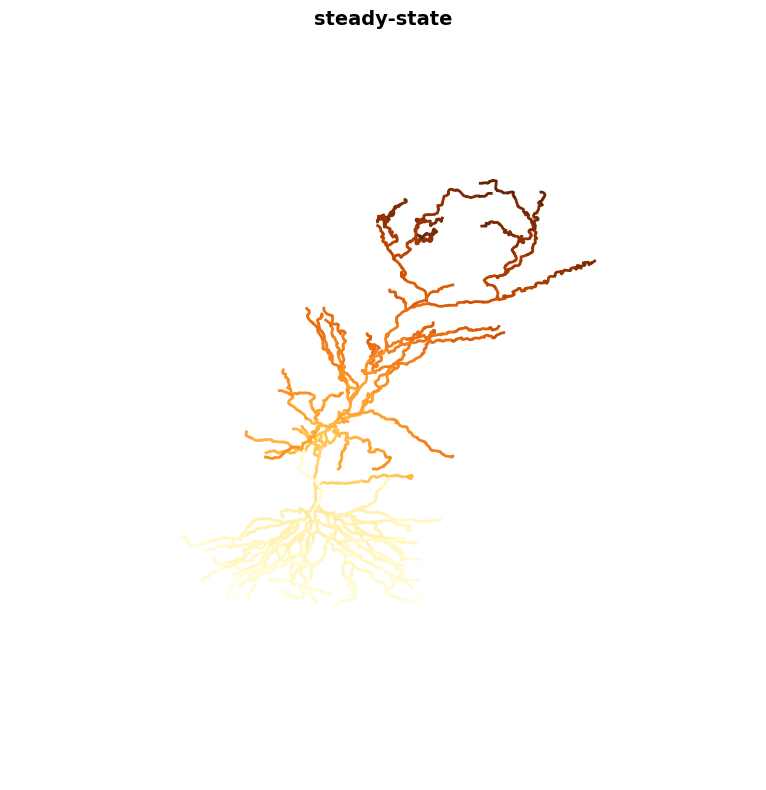

In [17]:
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= i
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"segment_distribution",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

2.0

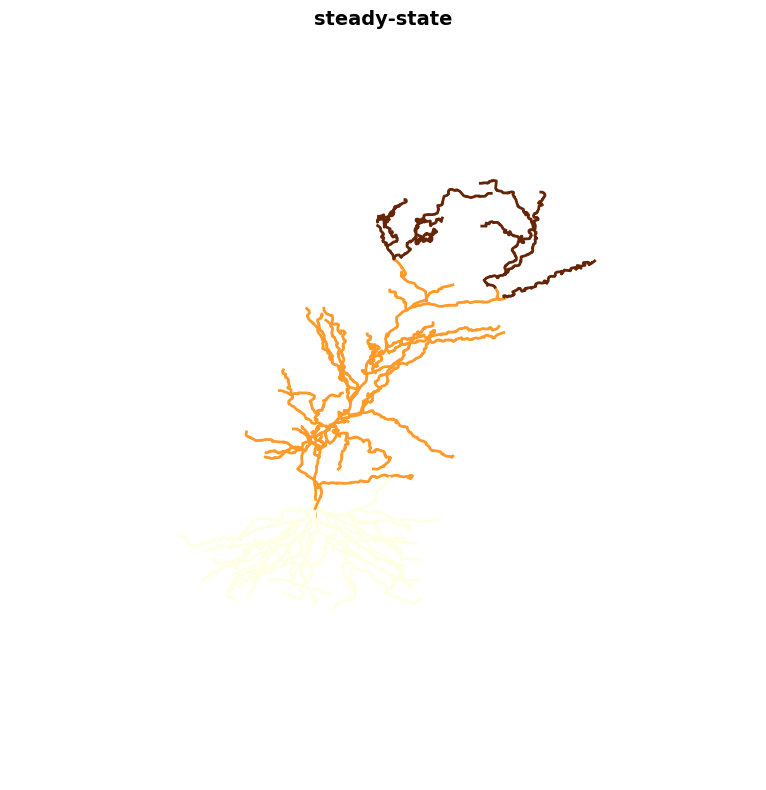

In [18]:
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    
    sidx= segIdx[abb]
    utarg[sidx] *= [j for j in range(len(subreg)) if subreg[j]== expD['Subregion'][i]][0]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"subregion_distribution",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

Day 0 3 month
------

23.066666666666666

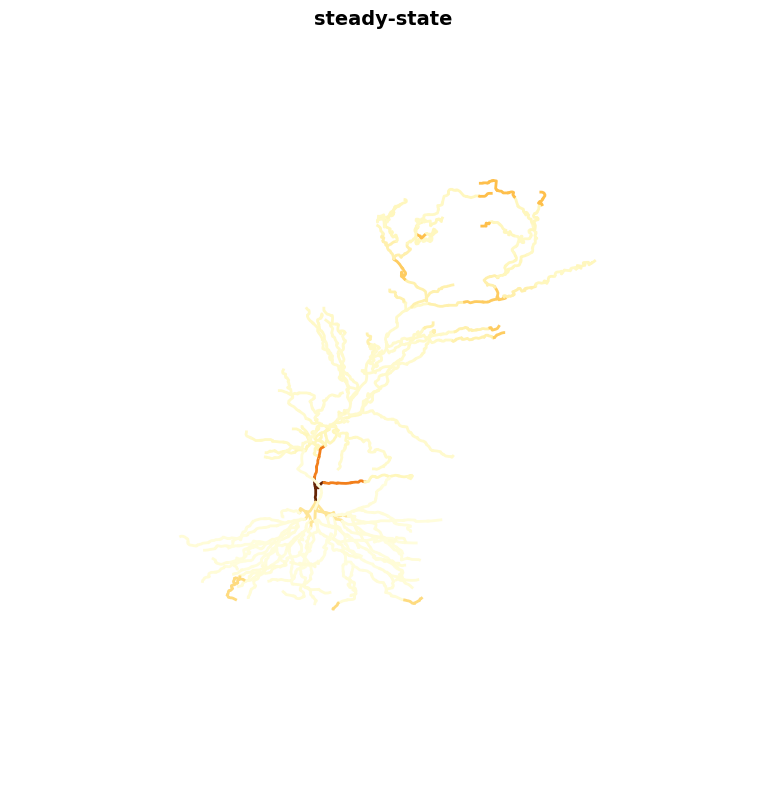

In [19]:
cname='D0M3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]/len(sidx)
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"reg20_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

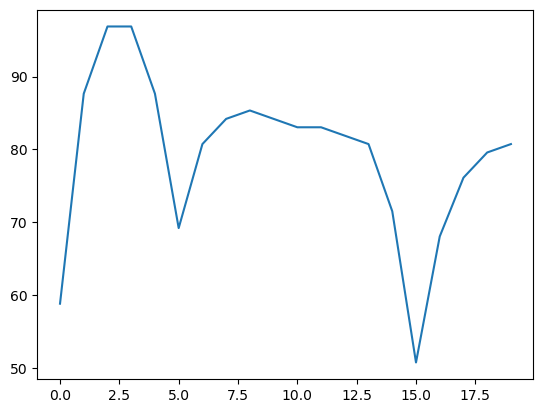

In [20]:
x=np.array(range(expD.shape[0]),dtype=int)
nobsD0 = np.array(expD[f"{cname}_MEAN"])#/np.sum(expD[f"{cname}_MEAN"])
plt.plot(x,nobsD0,label=cname)
plt.show()

In [21]:
cname7='D7M3'
obsD = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    obsD[sidx] *= expD[f"{cname7}_MEAN"][i]/len(sidx)
nobsD = np.array(expD[f"{cname7}_MEAN"])#/np.sum(expD[f"{cname}_MEAN"])
uD = np.concatenate((obsD,obsD))
utrace = [uD,uD]
utrace = np.array(utrace).T
max(obsD)

9.995555556666668

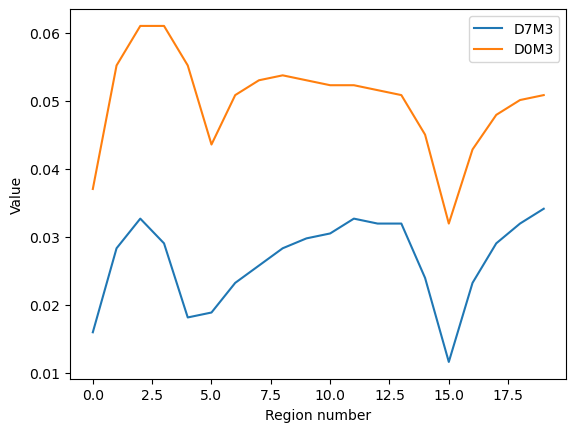

In [22]:
x=np.array(range(expD.shape[0]),dtype=int)
cname0='D0M3'
cname7='D7M3'

plt.plot(x,np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]),label=cname7)
plt.plot(x,np.array(expD[f"{cname0}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]),label=cname0)
plt.ylabel('Value')
plt.xlabel('Region number')
# show a legend on the plot
plt.legend()
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_202406161015_day0_day7.png')
plt.savefig('bestFitEdita_20reg_1dv_202406161015_day0_day7.pdf')
plt.savefig('bestFitEdita_20reg_1dv_202406161015_day0_day7.svg')


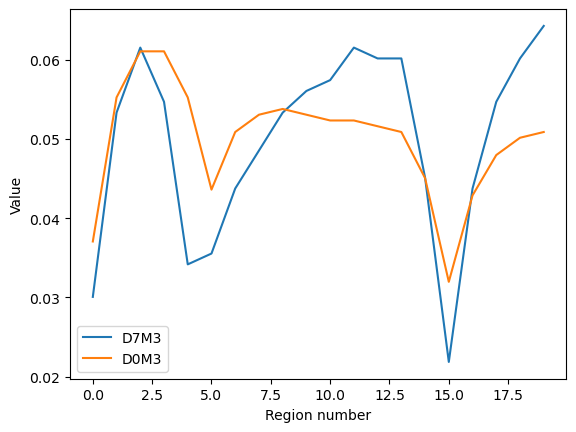

In [23]:
x=np.array(range(expD.shape[0]),dtype=int)
cname0='D0M3'
cname7='D7M3'

plt.plot(x,np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname7}_MEAN"]),label=cname7)
plt.plot(x,np.array(expD[f"{cname0}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]),label=cname0)
plt.ylabel('Value')
plt.xlabel('Region number')
# show a legend on the plot
plt.legend()
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_202406161015_day0_day7_unit.png')
plt.savefig('bestFitEdita_20reg_1dv_202406161015_day0_day7_unit.pdf')
plt.savefig('bestFitEdita_20reg_1dv_202406161015_day0_day7_unit.svg')


In [24]:
diF=abs(uD-u1)
utrace = [diF,diF]
utrace = np.array(utrace).T
(min(diF),max(diF))

(0.0, 13.071111109999999)

In [25]:
cname7='D7M3'
obsD = np.ones(len(seg_list))
resMo = np.zeros(expD.shape[0])
resFo = np.zeros(expD.shape[0])
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    obsD[sidx] *= expD[f"{cname7}_MEAN"][i]
    resMo[i] = np.sum(utrace[sidx,-1])
    resFo[i] = np.sum(utrace[[j+n for j in sidx],-1])
nobsD = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname7}_MEAN"])
nobsDnn = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD["D0M3_MEAN"])
nresM = resMo/np.sum(resMo)
nresF = resFo/np.sum(resFo)
(nobsD,nresM,nresF)

(array([0.03007519, 0.05331511, 0.06151743, 0.05468216, 0.03417635,
        0.0355434 , 0.04374573, 0.04853042, 0.05331511, 0.05604921,
        0.05741627, 0.06151743, 0.06015038, 0.06015038, 0.04511278,
        0.02187286, 0.04374573, 0.05468216, 0.06015038, 0.06425154]),
 array([0.04499612, 0.05740884, 0.06051202, 0.06826998, 0.07913111,
        0.05275407, 0.05896043, 0.05818464, 0.05430566, 0.04965089,
        0.04654771, 0.04189294, 0.04189294, 0.04034135, 0.04499612,
        0.04344453, 0.04189294, 0.04034135, 0.03878976, 0.03568658]),
 array([0.04499612, 0.05740884, 0.06051202, 0.06826998, 0.07913111,
        0.05275407, 0.05896043, 0.05818464, 0.05430566, 0.04965089,
        0.04654771, 0.04189294, 0.04189294, 0.04034135, 0.04499612,
        0.04344453, 0.04189294, 0.04034135, 0.03878976, 0.03568658]))

In [26]:
par = [1000,0,0,0,0]+[i+1 for i in range(expD.shape[0])]
par

[1000,
 0,
 0,
 0,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20]

In [27]:
i=0
abb = expD['Abbreviation'][i]
sidx = segIdx[abb]
(i,abb,sidx)

(0, 'CA1so_1', [651, 652, 661, 708, 709, 710, 711, 712, 717])

In [28]:
itarg = np.ones(len(seg_list), dtype=int)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx = segIdx[abb]
    itarg[sidx] *= i+5
utarg = [par[j] for j in itarg]
tgAbb = []
tgFnd = []
for i in itarg:
    if i>4:
        tgFnd.append(f'found:{i-5}')#
        tgAbb.append(expD['Abbreviation'][i-5])
    else:
        tgAbb.append('none')
        tgFnd.append('none')
itargDF=pd.DataFrame({'itarg':itarg,'utarg': utarg,'name':sname,'hname':hname,'abbCA1':abbCA1,'tgFnd':tgFnd,'tgAbb':tgAbb})
itargDF

,itarg,utarg,name,hname,abbCA1,tgFnd,tgAbb
0,1,0,soma[0],soma[0],Soma_0,none,none
1,1,0,soma[1],soma[1],Soma_0,none,none
2,10,6,dend_5[0],dend_5[0],CA1sr_1,found:5,CA1sr_1
3,10,6,apic[0],apic[0],CA1sr_1,found:5,CA1sr_1
4,11,7,apic[0],apic[0],CA1sr_2,found:6,CA1sr_2
...,...,...,...,...,...,...,...
737,1,0,axon[0],axon[0],NaN,none,none
738,1,0,axon[0],axon[0],NaN,none,none
739,1,0,axon[0],axon[0],NaN,none,none
740,1,0,axon[0],axon[0],NaN,none,none


In [29]:
itargDF.to_csv('itarg.csv')

In [30]:
lowb=np.array([0,-18,0,-18,-18,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07])
upbga=np.array([1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
Ndim=len(lowb)
(Ndim,len(lowb),len(upbga))

(25, 25, 25)

In [31]:
bgSignal = 1e-5
cname0='D0M3'
d0w = -1 * np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d0w[sidx] *= -1*expD[f"{cname0}_MEAN"][i]/len(sidx)
for i in range(N):
    if d0w[i]<0:
        d0w[i] = bgSignal
dinit = d0w/np.sum(d0w)

#cname='D7W3'
cname7='D7M3'
d7w = -1*np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d7w[sidx] *= -1 * expD[f"{cname7}_MEAN"][i]/len(sidx)
for i in range(N):
    if d7w[i]<0:
        d7w[i] = bgSignal
target = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]) #norm target to Day0 sum to take into accound degradation
targSD = np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname0}_MEAN"]) #measurement errors
tnorm = np.sum(target ** 2)
day7 = 7 * 24 * 3600 # final time point

itarg = np.ones(N, dtype=int)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx = segIdx[abb]
    itarg[sidx] *= (i+5)

def calcUtrace(par,delta=bgSignal,nframes=10):
    F = par[0]
    Ctau = 10 ** par[1]
    mProp = par[2]
    dvA = par[3]
    dvB = par[4]
    dv = np.zeros(N)
    utarg = delta*np.ones(N)
    for k in range(N):
        if itarg[k] > 4:
            utarg[k] = par[itarg[k]]
            dv[k] = (10 ** dvA) + (10 ** dvB)*utarg[k]
    utarg /= np.sum(utarg)
    K = np.sum(utarg) / N
    x = trafficking_solution(F * utarg + (1 - F) * K)
    a = (1 / (1 + x))
    a = list(a)
    b = list((1 / (1 + x ** -1)))
    l = list(dv)
    c = list(Ctau * utarg / (F * utarg + (1 - F) * K))
    d = list(np.zeros(N))
    A = sushi_system(a, b, c, d, l)
    u0 = np.concatenate((mProp * dinit, (1 - mProp) * dinit))
    utrace = sim_time(A, u0, day7,nframes=nframes)
    return utrace

#par = [0.111784701917933,-1,0.584647952749801,-5.40926182202759,-7.58373647291078,0.93075347720533,0.150119155946245,0.250026616923097,0.247923892623914,1,0.829698078092076,0.799680386796054,0.435204401984173,0.776990953492751,0.658564397472255,0.669466722069782,0.13217494651507,0.452337127435389,0.818398235362628,0.287266237055001,0.693374804035749,0.387600533946115,0.860396244028168,0.793857689742176,0.00234423876609767]
#cost=0.2289827
#par = [0.141527769926587,-1.04440055844237,0.381706990604462,-5.43766625150405,-12.234744035647,1,0.164098437336494,0.272405308568442,0.427804635567134,0.812746641751752,0.919149761897559,0.672064846552212,0.149965791068772,0.539839422213906,0.812188937409397,0.806685239524521,0.165041822978698,0.529423937850048,0.828384035574742,0.221525313745652,0.676304529167494,0.634182580029409,0.814899037032692,0.790009814378913,0.0884319910464033]
#cost=0.1914477
#par = [1.0,-18.0,0.339665263904274,-18.0,-0.1056091212860899,1.0,0.06274608035463802,4.4574543322602384e-07,0.02193672327975435,0.0870196802604857,8.738149616920519e-07,1.0,0.23641992030781905,0.20499095398769174,3.3139951083305927e-07,0.0264354594647535,1.0601425384202188e-07,0.018642526550405554,1.3229426155908984e-07,0.321659768251798,1.256853193752937e-06,0.9999991575763989,0.9008918582308576,1.0002936595814933e-07,1.0]
#cost = 0.00972634
#par = [0.18124010722657255,-18.0,0.4770849437408547,-18.0,-7.528208406834074,0.6335729107600226,0.28276999275111847,0.558910113544302,1.0,0.3929830308454687,0.2992123958197709,0.753091076326252,1.0,0.17238067898531845,1.0,1e-07,1.0,0.04290036974800929,0.9692956552909402,1.0,0.5346212757781438,1.0,0.28625682786833306,1e-07,1e-07]
#cost = 0.02659
#par = [0.32023059450279123,-6.327308855004608,0.627385538130974,-18.0,-17.999431588729976,0.06854654347167044,0.060486839296889444,0.04484900714349323,0.03490854158366522,0.00024252729610862994,0.32943753444660906,0.4029203029951907,0.12801603593190886,0.14871930210853104,0.14171491277653797,0.18024101228415457,0.18628112282529372,0.23357327869041905,0.4302044118823936,0.5008667022509936,0.0038157043176590766,0.2007104314288199,0.22494314014617123,0.31189759389623783,0.9999999999990268]
#cost = 0.001142
#par = [0.01385481065982917,-6.226265838840085,0.6709771115511489,-17.995913305482574,-16.696101588995024,0.21868548101204954,0.06211405206769383,0.048882353452234434,0.046632773486508856,1.9401449712242143e-06,0.7864443640945032,0.5632548318074286,0.14915702983161863,0.1491589398028194,0.13322800132469398,0.15668388533325328,0.17435550169553826,0.20436446923690443,0.37541096611836217,0.5260391371129066,0.043995168941356404,0.1970021740399707,0.19622524557390722,0.2758337024352678,0.9999999999613025]
#cost = 1.51e-09
#par = [0.0,-2.847372550934951,0.20430623530833164,-5.754630055624563,-5.8321723784857635,-6.0649088262203215,0.9999999999999993,0.9550522528085269,0.001]
#cost = 0.00010140231658948862
par = [0.8861278052764772,-5.358123919558814,0.3127455791698551,-5.7356821635860165,-17.999032750284783,0.21382364663804718,0.06074280874523973,0.04781382417616123,0.04562340830020193,1.0000000000039887e-07,0.7733439929081787,0.5543045057407645,0.1468913931288651,0.14710118884157364,0.1316203146580693,0.15499357159791044,0.17296720163305693,0.20287137824434023,0.3735878952746845,0.5243019440900127,0.043864102155039865,0.1966480252602025,0.19591970216660096,0.2755074889018492,0.9999999999999992]
cost = 3.331839554992909e-11
mProp = par[2]
utrace = calcUtrace(par)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)
bpar = par

In [32]:
np.log(2)/(10 ** par[3])/3600

104.76232395453026

In [33]:
{'F' : par[0],
'Ctau' : 10 ** par[1],
'mProp' : par[2],
'dvA': 10 ** par[3],
'dvB': 10 ** par[4],
'demand_CA1so_1' : par[5],
'demand_CA1so_2' : par[6],
'demand_CA1so_3' : par[7],
'demand_CA1so_4' : par[8],
'demand_CA1so_5' : par[9],
'demand_CA1sr_1' : par[10],
'demand_CA1sr_2' : par[11],
'demand_CA1sr_3' : par[12],
'demand_CA1sr_4' : par[13],
'demand_CA1sr_5' : par[14],
'demand_CA1sr_6' : par[15],
'demand_CA1sr_7' : par[16],
'demand_CA1sr_8' : par[17],
'demand_CA1sr_9' : par[18],
'demand_CA1sr_10' : par[19],
'demand_CA1slm_1' : par[20],
'demand_CA1slm_2' : par[21],
'demand_CA1slm_3' : par[22],
'demand_CA1slm_4' : par[23],
'demand_CA1slm_5' : par[24],
'sum_nobsDnn' : np.sum(nobsDnn),
'sum_nobsDnn^2' : np.sum(nobsDnn ** 2),
'sum_resM' : np.sum(resM),
'sum_resF' : np.sum(resF),
'sum_tot' : np.sum(resF)+np.sum(resM),
'err' : np.sum((resF/(1-mProp) - target) ** 2),
'err_norm' : np.sum((resF/(1-mProp) - target) ** 2)/tnorm,
'chi2' : np.sum(((resF/(1-mProp) - target)/targSD) ** 2),
'cost' : cost
}

{'F': 0.8861278052764772,
 'Ctau': 4.384055873241875e-06,
 'mProp': 0.3127455791698551,
 'dvA': 1.8378828974092036e-06,
 'dvB': 1.0022296567714719e-18,
 'demand_CA1so_1': 0.21382364663804718,
 'demand_CA1so_2': 0.06074280874523973,
 'demand_CA1so_3': 0.04781382417616123,
 'demand_CA1so_4': 0.04562340830020193,
 'demand_CA1so_5': 1.0000000000039887e-07,
 'demand_CA1sr_1': 0.7733439929081787,
 'demand_CA1sr_2': 0.5543045057407645,
 'demand_CA1sr_3': 0.1468913931288651,
 'demand_CA1sr_4': 0.14710118884157364,
 'demand_CA1sr_5': 0.1316203146580693,
 'demand_CA1sr_6': 0.15499357159791044,
 'demand_CA1sr_7': 0.17296720163305693,
 'demand_CA1sr_8': 0.20287137824434023,
 'demand_CA1sr_9': 0.3735878952746845,
 'demand_CA1sr_10': 0.5243019440900127,
 'demand_CA1slm_1': 0.043864102155039865,
 'demand_CA1slm_2': 0.1966480252602025,
 'demand_CA1slm_3': 0.19591970216660096,
 'demand_CA1slm_4': 0.2755074889018492,
 'demand_CA1slm_5': 0.9999999999999992,
 'sum_nobsDnn': 0.5316133720994574,
 'sum_nobsD

In [34]:
delta=bgSignal
F = par[0]
Ctau = 10 ** par[1]
mProp = par[2]
dvA = par[3]
dvB = par[4]
dv = np.zeros(N)
utarg = delta*np.ones(N)
for k in range(N):
    if itarg[k] > 4:
        utarg[k] = par[itarg[k]]
        dv[k] = (10 ** dvA) + (10 ** dvB)*utarg[k]
utarg /= np.sum(utarg)
K = np.sum(utarg) / N
x = trafficking_solution(F * utarg + (1 - F) * K)
a = (1 / (1 + x))
aM, aF = sushibelt.aggregate_segments(np.concatenate((list(a),list(a))), segIdx, expD['Abbreviation'], fun=np.sum)
b = list((1 / (1 + x ** -1)))
bM, bF = sushibelt.aggregate_segments(np.concatenate((b,b)), segIdx, expD['Abbreviation'], fun=np.sum)
l = list(dv)
dM, dF = sushibelt.aggregate_segments(np.concatenate((l,l)), segIdx, expD['Abbreviation'], fun=np.sum)
c = list(Ctau * utarg / (F * utarg + (1 - F) * K))
cM, cF = sushibelt.aggregate_segments(np.concatenate((c,c)), segIdx, expD['Abbreviation'], fun=np.sum)
uM, uF = sushibelt.aggregate_segments(np.concatenate((utarg,utarg)), segIdx, expD['Abbreviation'], fun=np.sum)
df=pd.DataFrame([aM,bM,cM,dM,uM,par[5:]],columns=expD['Abbreviation'],index=['a','b','c','d','utarg','demand'])
df.to_csv('Edita_20reg_1dv_experiment.sum.heatmap.csv')
df

Abbreviation,CA1so_1,CA1so_2,CA1so_3,CA1so_4,CA1so_5,CA1sr_1,CA1sr_2,CA1sr_3,CA1sr_4,CA1sr_5,CA1sr_6,CA1sr_7,CA1sr_8,CA1sr_9,CA1sr_10,CA1slm_1,CA1slm_2,CA1slm_3,CA1slm_4,CA1slm_5
a,4.511631,42.880808,67.923415,50.933325,7.705825e+00,1.500000,3.246461,14.570108,19.193839,25.152368,22.660130,23.553746,19.673835,10.597906,5.059005,6.381755,12.217644,18.512523,15.628277,4.823375
b,4.488369,42.119192,66.076585,49.066675,8.294175e+00,1.500000,2.753539,14.429892,17.806161,22.847632,21.339870,22.446254,18.326165,10.402094,3.940995,6.618245,11.782356,16.487477,13.371723,4.176625
c,0.000041,0.000324,0.000482,0.000355,4.398710e-10,0.000015,0.000029,0.000128,0.000163,0.000209,0.000195,0.000206,0.000173,0.000099,0.000043,0.000046,0.000109,0.000159,0.000135,0.000044
d,0.000017,0.000156,0.000246,0.000184,2.940613e-05,0.000006,0.000011,0.000053,0.000068,0.000088,0.000081,0.000085,0.000070,0.000039,0.000017,0.000024,0.000044,0.000064,0.000053,0.000017
utarg,0.018520,0.049689,0.061660,0.043907,1.539804e-08,0.022327,0.032007,0.040996,0.052380,0.060801,0.065631,0.076571,0.074191,0.075502,0.045412,0.005488,0.045420,0.065992,0.076891,0.086614
demand,0.213824,0.060743,0.047814,0.045623,1.000000e-07,0.773344,0.554305,0.146891,0.147101,0.131620,0.154994,0.172967,0.202871,0.373588,0.524302,0.043864,0.196648,0.195920,0.275507,1.000000


In [35]:
delta=bgSignal
F = par[0]
Ctau = 10 ** par[1]
mProp = par[2]
dvA = par[3]
dvB = par[4]
dv = np.zeros(N)
utarg = delta*np.ones(N)
for k in range(N):
    if itarg[k] > 4:
        utarg[k] = par[itarg[k]]
        dv[k] = (10 ** dvA) + (10 ** dvB)*utarg[k]
utarg /= np.sum(utarg)
K = np.sum(utarg) / N
x = trafficking_solution(F * utarg + (1 - F) * K)
a = (1 / (1 + x))
aM, aF = sushibelt.aggregate_segments(np.concatenate((list(a),list(a))), segIdx, expD['Abbreviation'], fun=np.mean)
b = list((1 / (1 + x ** -1)))
bM, bF = sushibelt.aggregate_segments(np.concatenate((b,b)), segIdx, expD['Abbreviation'], fun=np.mean)
l = list(dv)
dM, dF = sushibelt.aggregate_segments(np.concatenate((l,l)), segIdx, expD['Abbreviation'], fun=np.mean)
c = list(Ctau * utarg / (F * utarg + (1 - F) * K))
cM, cF = sushibelt.aggregate_segments(np.concatenate((c,c)), segIdx, expD['Abbreviation'], fun=np.mean)
uM, uF = sushibelt.aggregate_segments(np.concatenate((utarg,utarg)), segIdx, expD['Abbreviation'], fun=np.mean)
df=pd.DataFrame([aM,bM,cM,dM,uM,par[5:]],columns=expD['Abbreviation'],index=['a','b','c','d','utarg','demand'])
df.to_csv('Edita_20reg_1dv_experiment.mean.heatmap.csv')
df

Abbreviation,CA1so_1,CA1so_2,CA1so_3,CA1so_4,CA1so_5,CA1sr_1,CA1sr_2,CA1sr_3,CA1sr_4,CA1sr_5,CA1sr_6,CA1sr_7,CA1sr_8,CA1sr_9,CA1sr_10,CA1slm_1,CA1slm_2,CA1slm_3,CA1slm_4,CA1slm_5
a,0.501292,0.504480,0.506891,0.509333,4.816140e-01,0.500000,0.541077,0.502418,0.518752,0.524008,0.515003,0.512038,0.517732,0.504662,0.562112,0.490904,0.509069,0.528929,0.538906,0.535931
b,0.498708,0.495520,0.493109,0.490667,5.183860e-01,0.500000,0.458923,0.497582,0.481248,0.475992,0.484997,0.487962,0.482268,0.495338,0.437888,0.509096,0.490931,0.471071,0.461094,0.464069
c,0.000005,0.000004,0.000004,0.000004,2.749194e-11,0.000005,0.000005,0.000004,0.000004,0.000004,0.000004,0.000004,0.000005,0.000005,0.000005,0.000004,0.000005,0.000005,0.000005,0.000005
d,0.000002,0.000002,0.000002,0.000002,1.837883e-06,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
utarg,0.002058,0.000585,0.000460,0.000439,9.623776e-10,0.007442,0.005335,0.001414,0.001416,0.001267,0.001492,0.001665,0.001952,0.003595,0.005046,0.000422,0.001892,0.001885,0.002651,0.009624
demand,0.213824,0.060743,0.047814,0.045623,1.000000e-07,0.773344,0.554305,0.146891,0.147101,0.131620,0.154994,0.172967,0.202871,0.373588,0.524302,0.043864,0.196648,0.195920,0.275507,1.000000


In [36]:
(len(utarg),len(par[5:]),len(itarg))

(742, 20, 742)

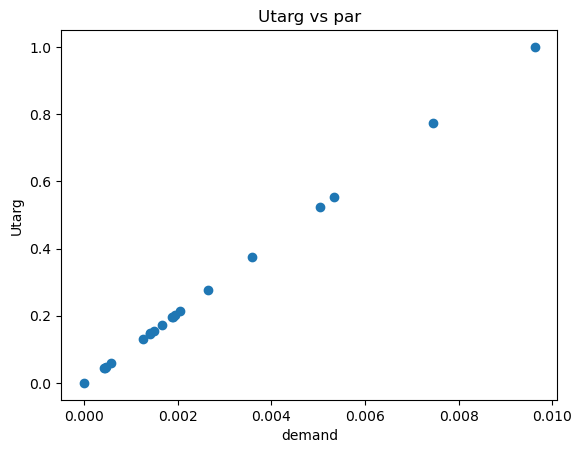

In [37]:
plt.scatter(uM,par[5:])
plt.title("Utarg vs par") 
plt.ylabel('Utarg')
plt.xlabel('demand')
plt.show()


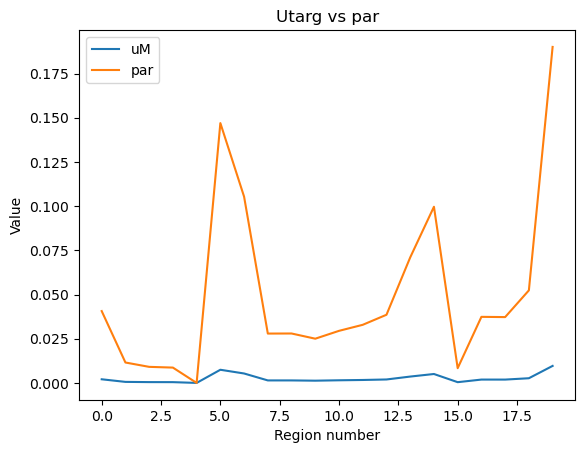

In [38]:
x=np.array(range(expD.shape[0]),dtype=int)
plt.plot(x,uM,label='uM')
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
plt.plot(x,par[5:]/np.sum(par[5:]),label='par')
plt.ylabel('Value')
plt.xlabel('Region number')
# show a legend on the plot
plt.legend()
plt.title("Utarg vs par") 
# function to show the plot
plt.show()


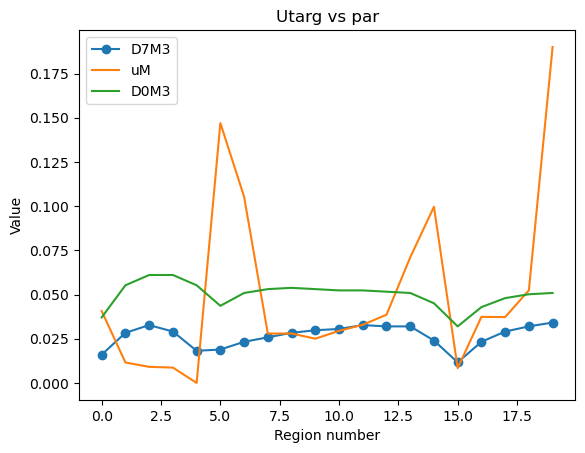

In [39]:
x=np.array(range(expD.shape[0]),dtype=int)
plt.plot(x,target,'o-',label=cname7)
plt.plot(x,uM/np.sum(uM),label='uM')
plt.plot(x,np.array(expD[f"{cname0}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]),label=cname0)
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
#plt.plot(x,par[5:]/np.sum(par[5:]),label='par')
plt.ylabel('Value')
plt.xlabel('Region number')
# show a legend on the plot
plt.legend()
plt.title("Utarg vs par") 
# function to show the plot
plt.show()


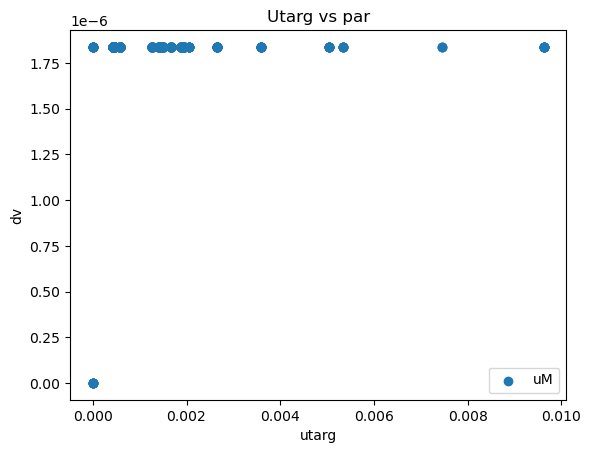

In [40]:
x=np.array(range(expD.shape[0]),dtype=int)
plt.scatter(utarg,dv,label='uM')
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
#plt.plot(x,par[5:]/np.sum(par[5:]),label='par')
plt.ylabel('dv')
plt.xlabel('utarg')
# show a legend on the plot
plt.legend()
plt.title("Utarg vs par") 
# function to show the plot
plt.show()


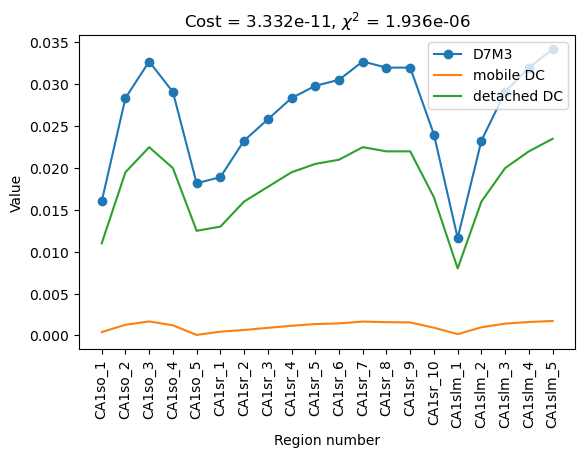

In [41]:
x=np.array(range(expD.shape[0]),dtype=int)
fig, ax = plt.subplots()
ax.plot(x,target,'o-',label=cname7)
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
ax.plot(x,resM,label='mobile DC')
ax.plot(x,resF,label='detached DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_202406161015best.png')
plt.savefig('bestFitEdita_20reg_1dv_202406161015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_202406161015best.svg')


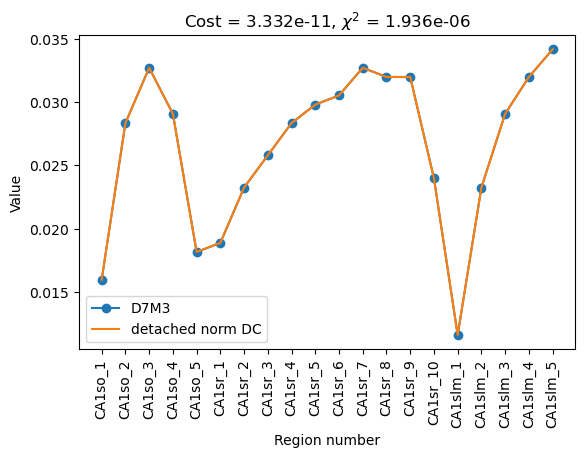

In [42]:
x=np.array(range(expD.shape[0]),dtype=int)
fig, ax = plt.subplots()
#ax.scatter(x,target,label=cname7)
ax.plot(x,target,'o-',label=cname7)
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
#ax.plot(x,resM,label='mobile DC')
#ax.plot(x,resF/(1-mProp),linestyle=':', linewidth=5,label='detached norm DC')
ax.plot(x,resF/(1-mProp),label='detached norm DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_norm202406161015best.png')
plt.savefig('bestFitEdita_20reg_1dv_norm202406161015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_norm202406161015best.svg')


In [43]:
?ax.scatter

Signature:
ax.scatter(
    x,
    y,
    s=None,
    c=None,
    marker=None,
    cmap=None,
    norm=None,
    vmin=None,
    vmax=None,
    alpha=None,
    linewidths=None,
    *,
    edgecolors=None,
    plotnonfinite=False,
    data=None,
    **kwargs,
)
Docstring:
A scatter plot of *y* vs. *x* with varying marker size and/or color.

Parameters
----------
x, y : float or array-like, shape (n, )
    The data positions.

s : float or array-like, shape (n, ), optional
    The marker size in points**2 (typographic points are 1/72 in.).
    Default is ``rcParams['lines.markersize'] ** 2``.

    The linewidth and edgecolor can visually interact with the marker
    size, and can lead to artifacts if the marker size is smaller than
    the linewidth.

    If the linewidth is greater than 0 and the edgecolor is anything
    but *'none'*, then the effective size of the marker will be
    increased by half the linewidth because the stroke will be centered
    on the edge of the shape.

    To

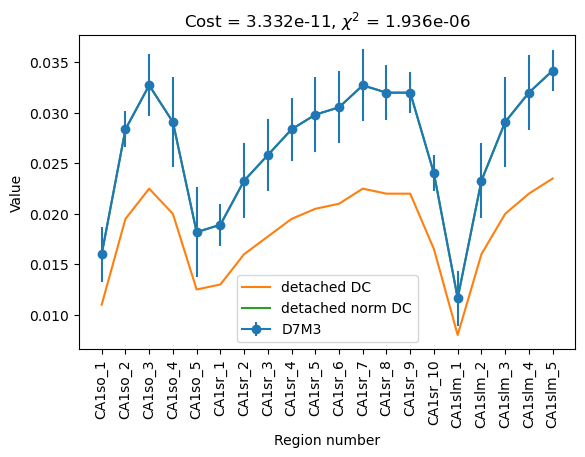

In [44]:
fig, ax = plt.subplots()
ax.errorbar(x,target,targSD,label=cname7, fmt='-o')
ax.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='detached norm DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
#plt.plot(x,resM+resF,label='total DC')
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_resF202406161015.png')
plt.savefig('bestFitEdita_20reg_1dv_resF202406161015.pdf')
plt.savefig('bestFitEdita_20reg_1dv_resF202406161015.svg')


## Apparent degradation rate

In [45]:
nframes = 50
utrace = calcUtrace(par,nframes=50)
t = np.logspace(-0.5,math.log10(day7),nframes)
(t,7*t/day7,utrace.shape,t.shape,utrace[:3,:])

(array([3.16227766e-01, 4.24811396e-01, 5.70679560e-01, 7.66634707e-01,
        1.02987528e+00, 1.38350519e+00, 1.85856157e+00, 2.49673881e+00,
        3.35404798e+00, 4.50573276e+00, 6.05287337e+00, 8.13125811e+00,
        1.09233011e+01, 1.46740524e+01, 1.97127050e+01, 2.64814879e+01,
        3.55744784e+01, 4.77897436e+01, 6.41993837e+01, 8.62436280e+01,
        1.15857240e+02, 1.55639324e+02, 2.09081446e+02, 2.80874074e+02,
        3.77318250e+02, 5.06878617e+02, 6.80926333e+02, 9.14737089e+02,
        1.22883182e+03, 1.65077775e+03, 2.21760792e+03, 2.97907148e+03,
        4.00199998e+03, 5.37617307e+03, 7.22219816e+03, 9.70209581e+03,
        1.30335199e+04, 1.75088603e+04, 2.35209054e+04, 3.15973161e+04,
        4.24469366e+04, 5.70220087e+04, 7.66017464e+04, 1.02904610e+05,
        1.38239129e+05, 1.85706518e+05, 2.49472860e+05, 3.35134752e+05,
        4.50210504e+05, 6.04800000e+05]),
 array([3.66004359e-06, 4.91679857e-06, 6.60508750e-06, 8.87308688e-06,
        1.19198528e-05

In [46]:
resList=[]
for i in range(nframes):
    resm, resf = sushibelt.aggregate_segments(utrace[:, i+1], segIdx, expD['Abbreviation'], fun=np.sum)
    resList.append(resf)
resfree = np.array(resList)
(resF.shape,resfree.shape)

((20,), (50, 20))

In [47]:
dvA = par[3]
dvB = par[4]
dv = (10 ** dvA) + (10 ** dvB)*np.array(par[5:])
(expD.shape,expD['Abbreviation'],par[5:],dv,np.log(2)*7/(np.array(dv * day7)))

((20, 14),
 0      CA1so_1
 1      CA1so_2
 2      CA1so_3
 3      CA1so_4
 4      CA1so_5
 5      CA1sr_1
 6      CA1sr_2
 7      CA1sr_3
 8      CA1sr_4
 9      CA1sr_5
 10     CA1sr_6
 11     CA1sr_7
 12     CA1sr_8
 13     CA1sr_9
 14    CA1sr_10
 15    CA1slm_1
 16    CA1slm_2
 17    CA1slm_3
 18    CA1slm_4
 19    CA1slm_5
 Name: Abbreviation, dtype: object,
 [0.21382364663804718,
  0.06074280874523973,
  0.04781382417616123,
  0.04562340830020193,
  1.0000000000039887e-07,
  0.7733439929081787,
  0.5543045057407645,
  0.1468913931288651,
  0.14710118884157364,
  0.1316203146580693,
  0.15499357159791044,
  0.17296720163305693,
  0.20287137824434023,
  0.3735878952746845,
  0.5243019440900127,
  0.043864102155039865,
  0.1966480252602025,
  0.19591970216660096,
  0.2755074889018492,
  0.9999999999999992],
 array([1.8378829e-06, 1.8378829e-06, 1.8378829e-06, 1.8378829e-06,
        1.8378829e-06, 1.8378829e-06, 1.8378829e-06, 1.8378829e-06,
        1.8378829e-06, 1.8378829e-06, 1.8

(-0.013231552611173543,
 -3.2260130187957676,
 'LR equation: $Y = -3226013.019\\ 10^{-6} + -13231.553\\ 10^{-6}\\ X$')

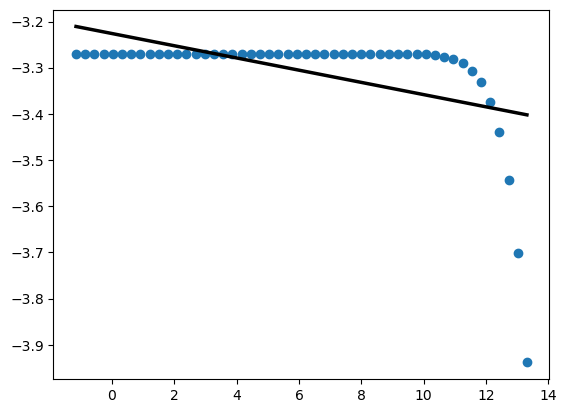

In [48]:
i = 1
bfit, afit = np.polyfit(np.log(t), np.log(resfree[:,i]), deg=1)
plt.scatter(np.log(t), np.log(resfree[:,i]))
plt.plot(np.log(t), afit + bfit * np.log(t), color="k", lw=2.5)
(bfit, afit,f'LR equation: $Y = {round(afit*1e6,3)}'+'\\ 10^{-6}'+f' + {round(bfit*1e6,3)}'+'\\ 10^{-6}\\ X$')

In [49]:
alpha = (np.log(resfree[0,i])-np.log(resfree[-1,i]))/day7
t_half = np.log(2)*7/(alpha * day7)
(alpha, t_half,format(alpha, ".2g"))

(1.1031376666545654e-06, 7.272471110850543, '1.1e-06')

In [50]:
x = 7*t/day7
alpha = np.zeros(expD.shape[0])
for i in range(expD.shape[0]):
    alpha[i] = (np.log(resfree[0,i])-np.log(resfree[-1,i]))/day7
    t_half = np.log(2)*7/(alpha[i] * day7)
    plt.plot(x,resfree[:,i],label=f"{expD['Abbreviation'][i]}")
    plt.scatter(x,resfree[:,i])
    plt.ylabel('Value')
    plt.xlabel('Time (days)')
    # show a legend on the plot
    plt.legend()
    plt.title(f"{expD['Abbreviation'][i]}: $\\alpha$ = {format(alpha[i], '.2g')}, T = {format(t_half, '.2g')} days.") 
    #plt.show()
    plt.savefig(f"Edita_20reg_1dv_resF_{expD['Abbreviation'][i]}_202406161015.png")
    plt.savefig(f"Edita_20reg_1dv_resF_{expD['Abbreviation'][i]}_202406161015.pdf")
    plt.savefig(f"Edita_20reg_1dv_resF_{expD['Abbreviation'][i]}_202406161015.svg")
    plt.close()



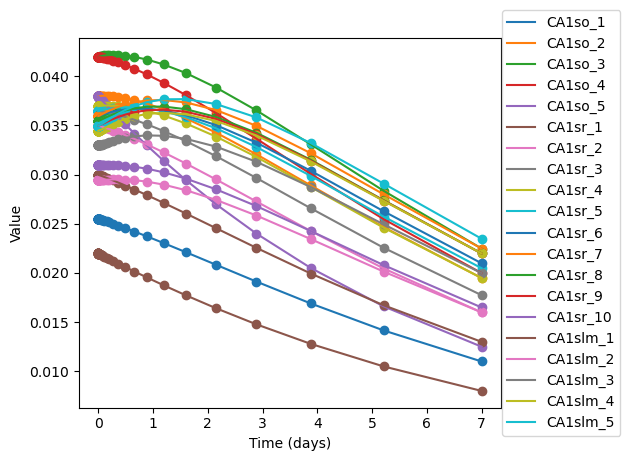

In [51]:
x = 7*t/day7
alpha = np.zeros(expD.shape[0])
fig, ax = plt.subplots()
for i in range(expD.shape[0]):
    alpha[i] = (np.log(resfree[0,i])-np.log(resfree[-1,i]))/day7
    t_half = np.log(2)*7/(alpha[i] * day7)
    ax.plot(x,resfree[:,i],label=f"{expD['Abbreviation'][i]}")
    ax.scatter(x,resfree[:,i])
ax.set_ylabel('Value')
ax.set_xlabel('Time (days)')
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.85, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
# show a legend on the plot
plt.savefig(f"Edita_20reg_1dv_resF_202406161015.png")
plt.savefig(f"Edita_20reg_1dv_resF_202406161015.pdf")
plt.savefig(f"Edita_20reg_1dv_resF_202406161015.svg")



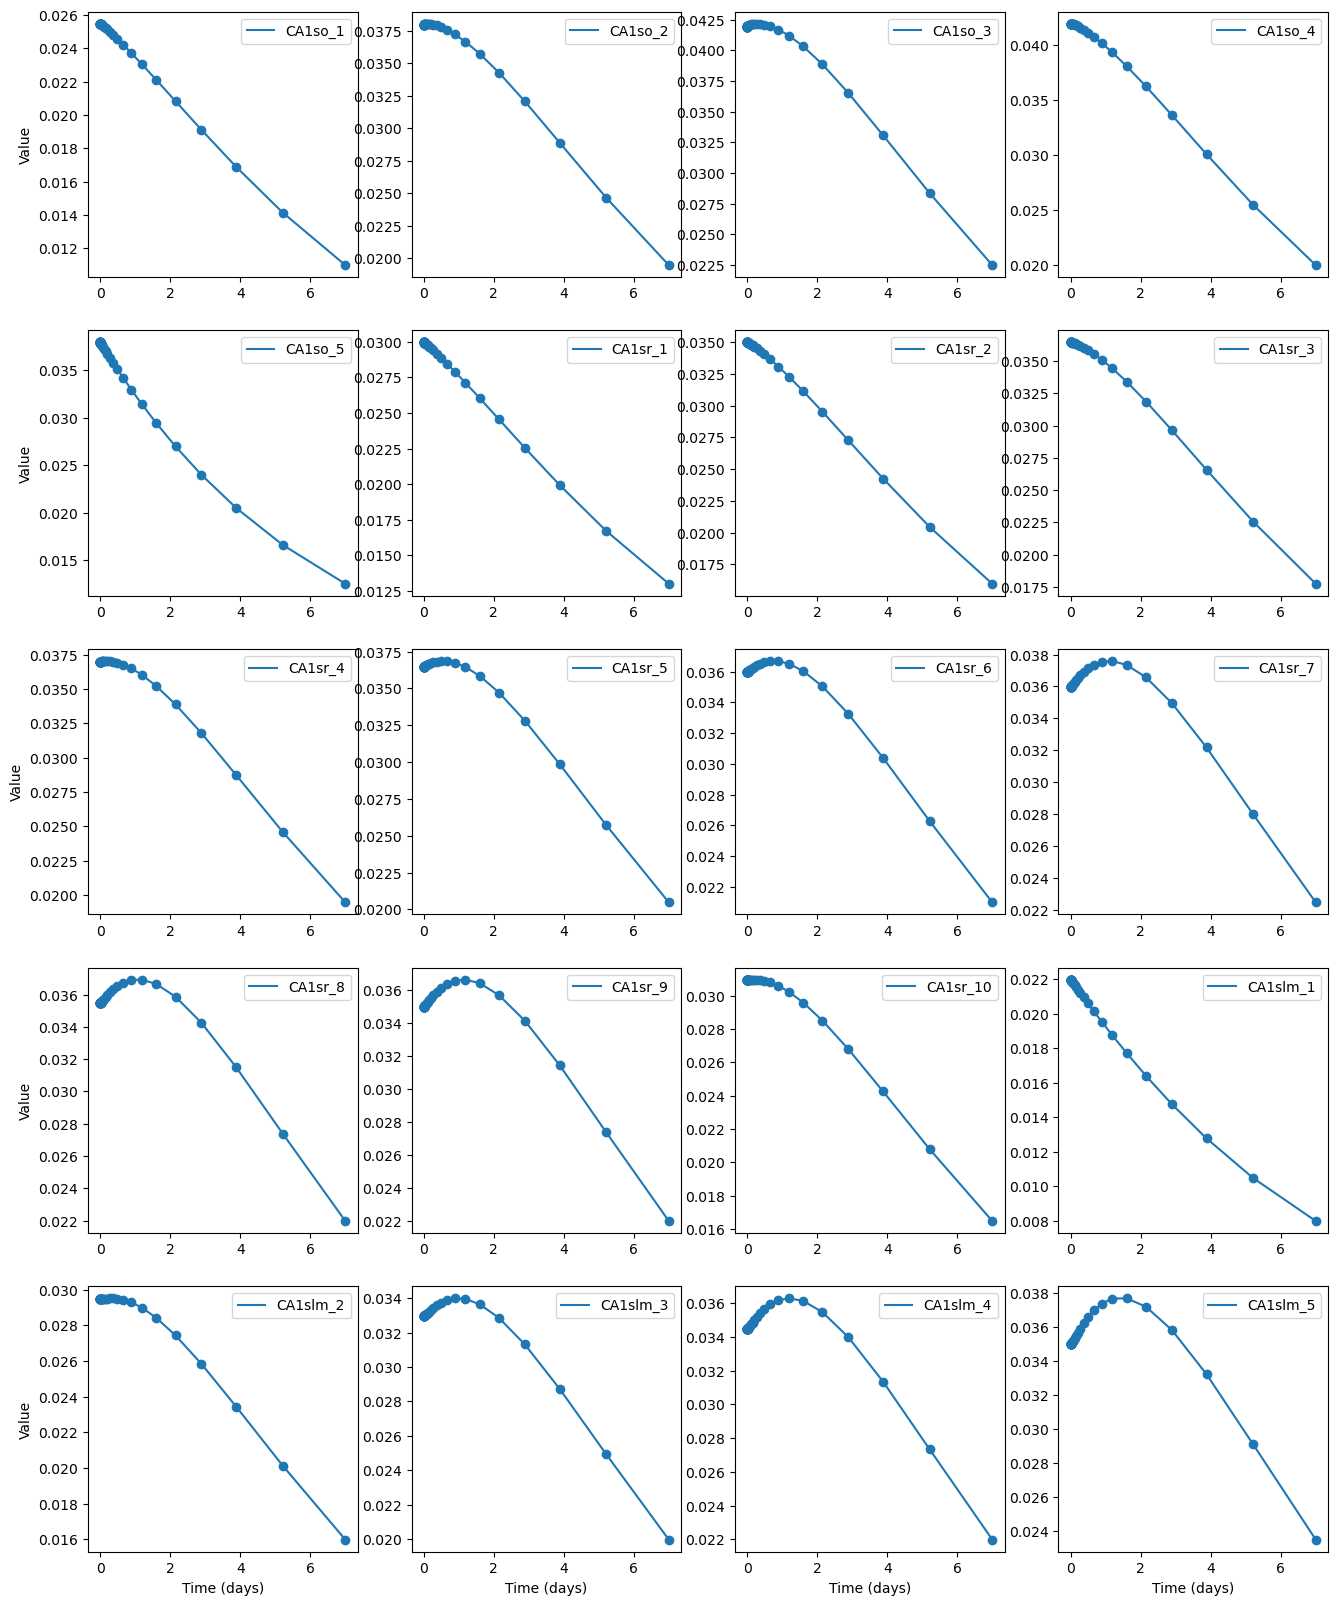

In [52]:
x = 7*t/day7
alpha = np.zeros(expD.shape[0])
fig, axes = plt.subplots(5, 4, figsize=(16, 20))

k = 0
for i in range(5):
    for j in range(4):
        alpha[k] = (np.log(resfree[0,k])-np.log(resfree[-1,k]))/day7
        t_half = np.log(2)*7/(alpha[k] * day7)
        axes[i,j].plot(x,resfree[:,k],label=f"{expD['Abbreviation'][k]}")
        axes[i,j].scatter(x,resfree[:,k])
        axes[i,j].legend()
        if i == 4 :
            axes[i,j].set_xlabel('Time (days)')
        if j == 0 :
            axes[i,j].set_ylabel('Value')
        k += 1
#plt.ylabel('Value')
#plt.xlabel('Time (days)')
# show a legend on the plot
#plt.legend(bbox_to_anchor = (1.05,1.04),loc='upper left')
plt.savefig(f"Edita_20reg_1dv_resF_panels_202406161015.png")
plt.savefig(f"Edita_20reg_1dv_resF_panels_202406161015.pdf")
plt.savefig(f"Edita_20reg_1dv_resF_panels_202406161015.svg")



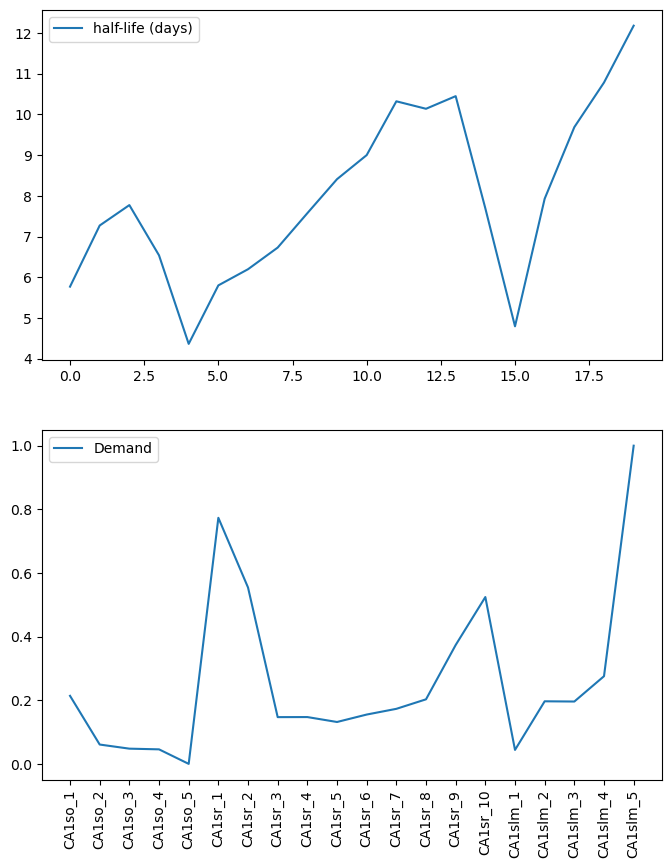

In [53]:
x=np.array(range(expD.shape[0]),dtype=int)
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

axes[0].plot(x,np.log(2)*7/(alpha * day7),label='half-life (days)')
#axes[0].xlabel('Region number')
#axes[0].ylabel('Apparent half-life (days)')
# show a legend on the plot
axes[0].legend()
plt.xticks(x,expD['Abbreviation'],rotation=90)
axes[1].plot(x,par[5:],label=f'Demand')
#axes[1].xlabel('Region number')
#axes[1].ylabel('Demand')
# show a legend on the plot
axes[1].legend()
#plt.show()
plt.savefig('Edita_20reg_1dv_A_demand202406161015.png')
plt.savefig('Edita_20reg_1dv_A_demand202406161015.pdf')
plt.savefig('Edita_20reg_1dv_A_demand202406161015.svg')


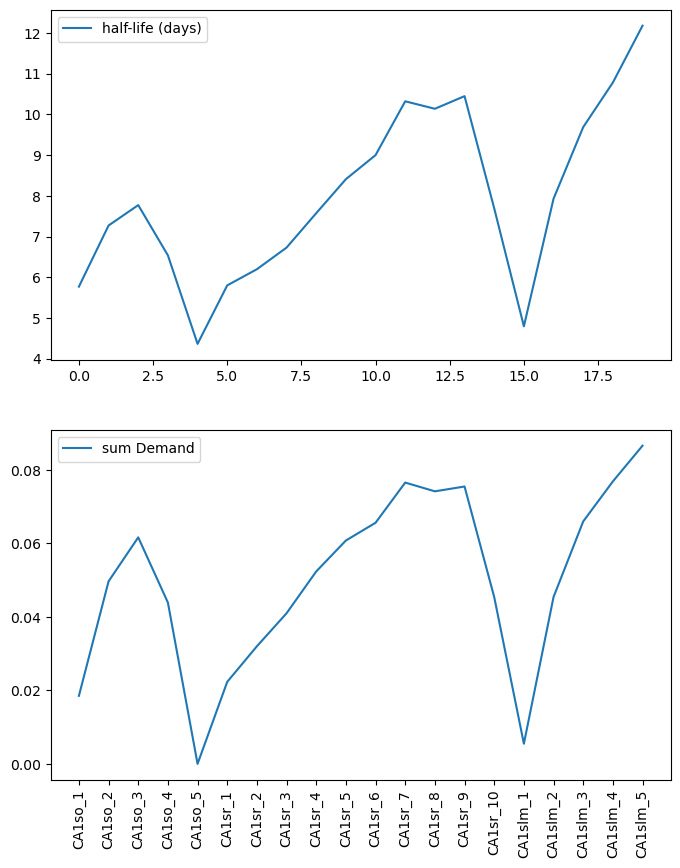

In [54]:
x=np.array(range(expD.shape[0]),dtype=int)
uS, uS = sushibelt.aggregate_segments(np.concatenate((utarg,utarg)), segIdx, expD['Abbreviation'], fun=np.sum)
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

axes[0].plot(x,np.log(2)*7/(alpha * day7),label='half-life (days)')
#axes[0].xlabel('Region number')
#axes[0].ylabel('Apparent half-life (days)')
# show a legend on the plot
axes[0].legend()
plt.xticks(x,expD['Abbreviation'],rotation=90)
axes[1].plot(x,uS,label=f'sum Demand')
#axes[1].xlabel('Region number')
#axes[1].ylabel('Demand')
# show a legend on the plot
axes[1].legend()
plt.show()
#plt.savefig('Edita_20reg_1dv_A_demand202406161015.png')
#plt.savefig('Edita_20reg_1dv_A_demand202406161015.pdf')
#plt.savefig('Edita_20reg_1dv_A_demand202406161015.svg')


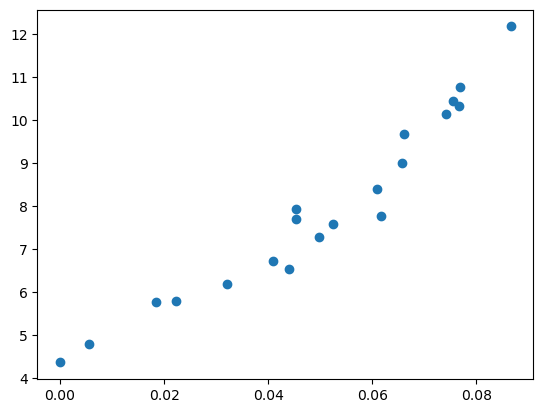

In [55]:
x=np.array(range(expD.shape[0]),dtype=int)
uS, uS = sushibelt.aggregate_segments(np.concatenate((utarg,utarg)), segIdx, expD['Abbreviation'], fun=np.sum)
#fig, axes = plt.subplots(2, 1, figsize=(8, 10))

plt.scatter(uS,np.log(2)*7/(alpha * day7),label='half-life (days)')
plt.show()
#plt.savefig('Edita_20reg_1dv_A_demand202406161015.png')
#plt.savefig('Edita_20reg_1dv_A_demand202406161015.pdf')
#plt.savefig('Edita_20reg_1dv_A_demand202406161015.svg')


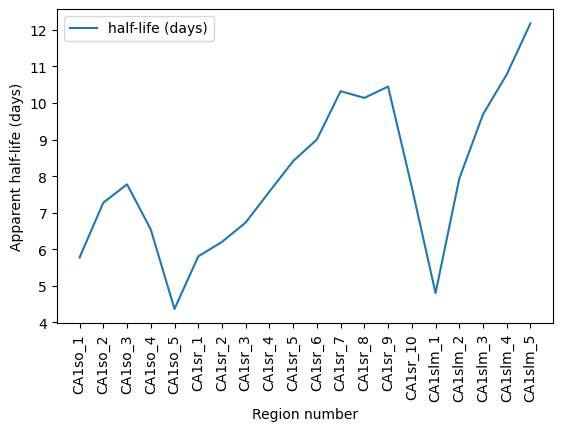

In [56]:
A = (np.log(expD[f"{cname0}_MEAN"])-np.log(expD[f"{cname7}_MEAN"]))/day7
fig, ax = plt.subplots()
ax.plot(x,np.log(2)*7/(A * day7),label='half-life (days)')
ax.set_xlabel('Region number')
ax.set_ylabel('Apparent half-life (days)')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.savefig('Edita_20reg_1dv_A_202406161015.png')
plt.savefig('Edita_20reg_1dv_A_202406161015.pdf')
plt.savefig('Edita_20reg_1dv_A_202406161015.svg')


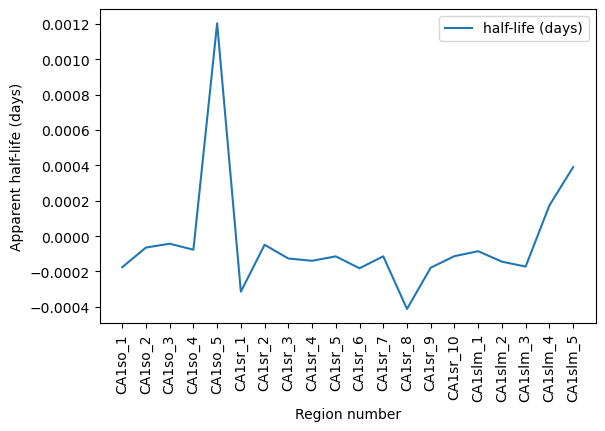

In [57]:
fig, ax = plt.subplots()
ax.plot(x,(np.log(2)*7/(alpha * day7)-np.log(2)*7/(A * day7)),label='half-life (days)')
ax.set_xlabel('Region number')
ax.set_ylabel('Apparent half-life (days)')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.show()

In [58]:
(A,dv)

(0     1.390184e-06
 1     1.103128e-06
 2     1.032001e-06
 3     1.226748e-06
 4     1.838389e-06
 5     1.382685e-06
 6     1.294245e-06
 7     1.192009e-06
 8     1.059033e-06
 9     9.538482e-07
 10    8.911979e-07
 11    7.771224e-07
 12    7.911545e-07
 13    7.677011e-07
 14    1.042703e-06
 15    1.672621e-06
 16    1.011577e-06
 17    8.280015e-07
 18    7.439102e-07
 19    6.586436e-07
 dtype: float64,
 array([1.8378829e-06, 1.8378829e-06, 1.8378829e-06, 1.8378829e-06,
        1.8378829e-06, 1.8378829e-06, 1.8378829e-06, 1.8378829e-06,
        1.8378829e-06, 1.8378829e-06, 1.8378829e-06, 1.8378829e-06,
        1.8378829e-06, 1.8378829e-06, 1.8378829e-06, 1.8378829e-06,
        1.8378829e-06, 1.8378829e-06, 1.8378829e-06, 1.8378829e-06]))

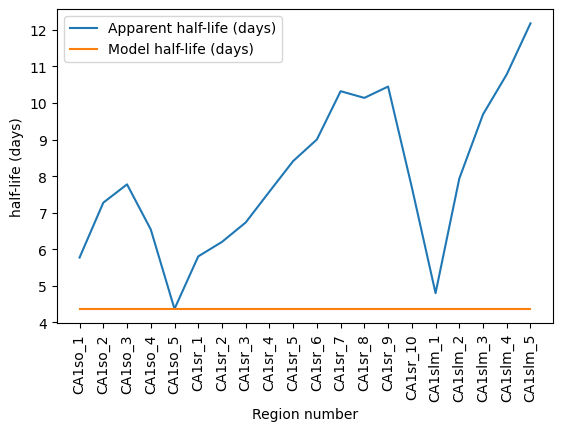

In [59]:
A = (np.log(expD[f"{cname0}_MEAN"])-np.log(expD[f"{cname7}_MEAN"]))/day7
dvB = par[4]
dv = (10 ** dvA) + (10 ** dvB)*np.array(par[5:])
fig, ax = plt.subplots()
ax.plot(x,np.log(2)*7/(A * day7),label='Apparent half-life (days)')
ax.plot(x,np.log(2)*7/(dv * day7),label='Model half-life (days)')
ax.set_xlabel('Region number')
ax.set_ylabel('half-life (days)')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.savefig('Edita_20reg_1dv_twoHalfLifes_202406161015.png')
plt.savefig('Edita_20reg_1dv_twoHalfLifes_202406161015.pdf')
plt.savefig('Edita_20reg_1dv_twoHalfLifes_202406161015.svg')


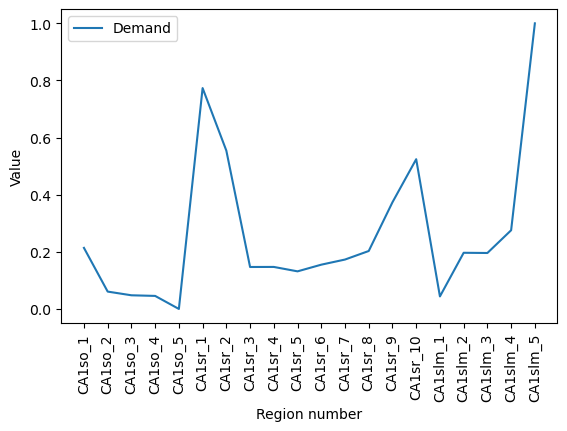

In [60]:
fig, ax = plt.subplots()
ax.plot(x,par[5:],label=f'Demand')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
#plt.show()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.savefig('Edita_20reg_1dv_demand202406161015.png')
plt.savefig('Edita_20reg_1dv_demand202406161015.pdf')
plt.savefig('Edita_20reg_1dv_demand202406161015.svg')


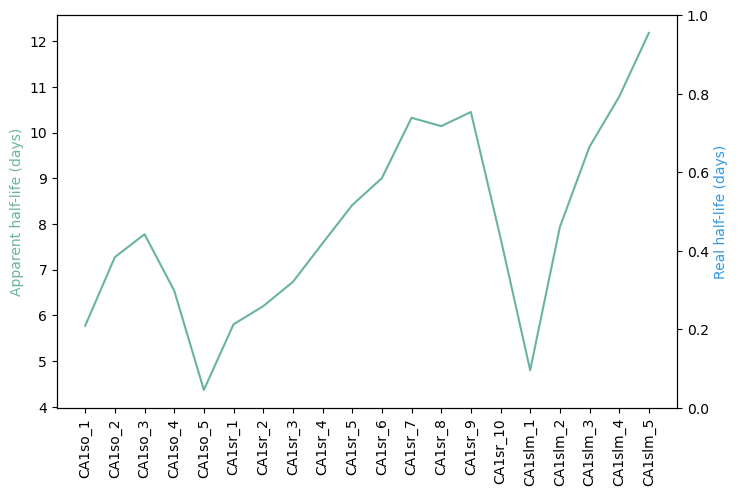

In [61]:
COLOR_alpha = "#69b3a2"
COLOR_demand = "#3399e6"
fig, ax1 = plt.subplots(figsize=(8, 6))
# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylim(0, 1)
ax1.plot(x,np.log(2)*7/(alpha * day7),color = COLOR_alpha)
ax1.set_ylabel('Apparent half-life (days)',color = COLOR_alpha)
ax2.plot(x,np.log(2)*7/(dv * day7),color = COLOR_demand)
ax2.set_ylabel('Real half-life (days)',color = COLOR_demand)
ax1.set_xticks(x,expD['Abbreviation'],rotation=90)
pos = ax1.get_position()
ax1.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
#pos = ax2.get_position()
#ax2.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
#plt.show()
plt.savefig('Edita_20reg_1dv_Adv202406161015.png')
plt.savefig('Edita_20reg_1dv_Adv202406161015.pdf')
plt.savefig('Edita_20reg_1dv_Adv202406161015.svg')


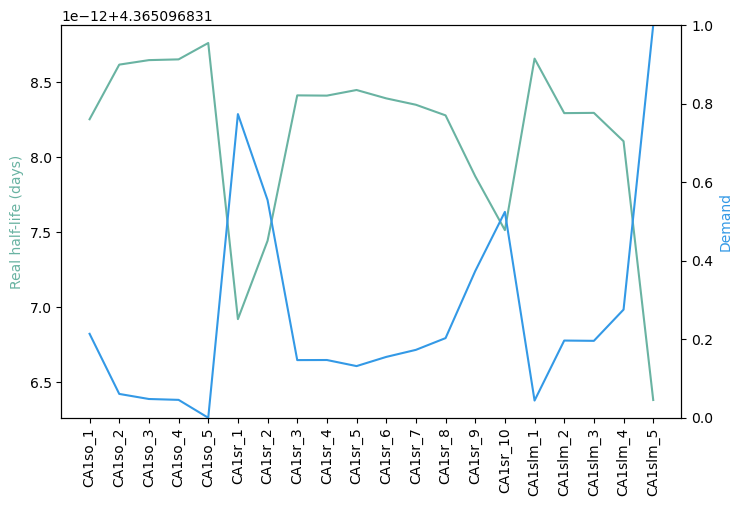

In [62]:
COLOR_alpha = "#69b3a2"
COLOR_demand = "#3399e6"
fig, ax1 = plt.subplots(figsize=(8, 6))
# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylim(0, 1)
ax1.plot(x,np.log(2)*7/(dv * day7),color = COLOR_alpha)
ax1.set_ylabel('Real half-life (days)',color = COLOR_alpha)
ax2.plot(x,par[5:],color = COLOR_demand)
ax2.set_ylabel('Demand',color = COLOR_demand)
ax1.set_xticks(x,expD['Abbreviation'],rotation=90)
pos = ax1.get_position()
ax1.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
#pos = ax2.get_position()
#ax2.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
#plt.show()
plt.savefig('Edita_20reg_1dv_dvdemand202406161015.png')
plt.savefig('Edita_20reg_1dv_dvdemand202406161015.pdf')
plt.savefig('Edita_20reg_1dv_dvdemand202406161015.svg')


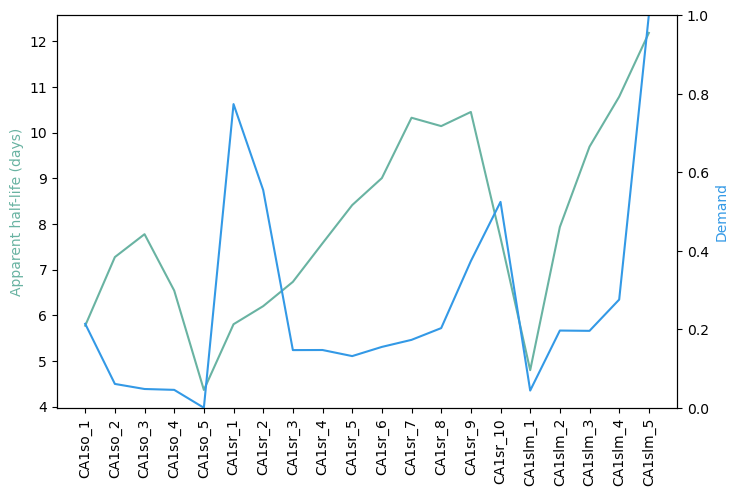

In [63]:
COLOR_alpha = "#69b3a2"
COLOR_demand = "#3399e6"
fig, ax1 = plt.subplots(figsize=(8, 6))
# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylim(0, 1)
ax1.plot(x,np.log(2)*7/(A * day7),color = COLOR_alpha)
ax1.set_ylabel('Apparent half-life (days)',color = COLOR_alpha)
ax2.plot(x,par[5:],color = COLOR_demand)
ax2.set_ylabel('Demand',color = COLOR_demand)
ax1.set_xticks(x,expD['Abbreviation'],rotation=90)
pos = ax1.get_position()
ax1.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
#pos = ax2.get_position()
#ax2.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
#plt.show()
plt.savefig('Edita_20reg_1dv_Ademand202406161015.png')
plt.savefig('Edita_20reg_1dv_Ademand202406161015.pdf')
plt.savefig('Edita_20reg_1dv_Ademand202406161015.svg')


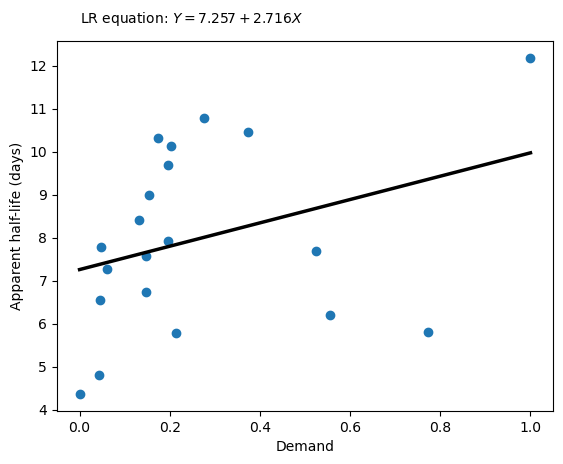

In [64]:
bfit, afit = np.polyfit(par[5:],np.log(2)*7/(A * day7), deg=1)
xseq = np.linspace(min(par[5:]), max(par[5:]), num=100)
plt.scatter(par[5:],np.log(2)*7/(A * day7))
plt.plot(xseq, afit + bfit * xseq, color="k", lw=2.5)
plt.text(0, 13, f'LR equation: $Y = {round(afit,3)} + {round(bfit,3)} X$', fontsize=10)
plt.xlabel('Demand')
plt.ylabel('Apparent half-life (days)')
# show a legend on the plot
#plt.show()
plt.savefig('Edita_20reg_1dv_T_vs_demand202406161015.png')
plt.savefig('Edita_20reg_1dv_T_vs_demand202406161015.pdf')
plt.savefig('Edita_20reg_1dv_T_vs_demand202406161015.svg')


In [65]:
delta=bgSignal
F = par[0]
Ctau = 10 ** par[1]
mProp = par[2]
dvA = par[3]
dvB = par[4]
dv = np.zeros(N)
utarg = delta*np.ones(N)
for k in range(N):
    if itarg[k] > 4:
        utarg[k] = par[itarg[k]]
        dv[k] = (10 ** dvA) + (10 ** dvB)*utarg[k]
utarg /= np.sum(utarg)
K = np.sum(utarg) / N
x = trafficking_solution(F * utarg + (1 - F) * K)
a = (1 / (1 + x))
aM, aF = sushibelt.aggregate_segments(np.concatenate((list(a),list(a))), segIdx, expD['Abbreviation'], fun=np.mean)
b = list((1 / (1 + x ** -1)))
bM, bF = sushibelt.aggregate_segments(np.concatenate((b,b)), segIdx, expD['Abbreviation'], fun=np.mean)
l = list(dv)
dM, dF = sushibelt.aggregate_segments(np.concatenate((l,l)), segIdx, expD['Abbreviation'], fun=np.mean)
c = list(Ctau * utarg / (F * utarg + (1 - F) * K))
cM, cF = sushibelt.aggregate_segments(np.concatenate((c,c)), segIdx, expD['Abbreviation'], fun=np.mean)
uM, uF = sushibelt.aggregate_segments(np.concatenate((utarg,utarg)), segIdx, expD['Abbreviation'], fun=np.mean)
df=pd.DataFrame([aM,bM,cM,dM,uM,par[5:],A,np.log(2)*7/(A * day7)],columns=expD['Abbreviation'],index=['a','b','c','d','utarg','demand','A','aT1/2'])
df.to_csv('Edita_20reg_1dv_experiment.mean.heatmap.csv')
df

Abbreviation,CA1so_1,CA1so_2,CA1so_3,CA1so_4,CA1so_5,CA1sr_1,CA1sr_2,CA1sr_3,CA1sr_4,CA1sr_5,CA1sr_6,CA1sr_7,CA1sr_8,CA1sr_9,CA1sr_10,CA1slm_1,CA1slm_2,CA1slm_3,CA1slm_4,CA1slm_5
a,0.501292,0.504480,0.506891,0.509333,4.816140e-01,0.500000,0.541077,0.502418,0.518752,5.240077e-01,5.150029e-01,5.120380e-01,5.177325e-01,5.046622e-01,0.562112,0.490904,0.509069,5.289292e-01,5.389061e-01,5.359305e-01
b,0.498708,0.495520,0.493109,0.490667,5.183860e-01,0.500000,0.458923,0.497582,0.481248,4.759923e-01,4.849971e-01,4.879620e-01,4.822675e-01,4.953378e-01,0.437888,0.509096,0.490931,4.710708e-01,4.610939e-01,4.640695e-01
c,0.000005,0.000004,0.000004,0.000004,2.749194e-11,0.000005,0.000005,0.000004,0.000004,4.352354e-06,4.432757e-06,4.481198e-06,4.544324e-06,4.720064e-06,0.000005,0.000004,0.000005,4.531224e-06,4.644084e-06,4.859971e-06
d,0.000002,0.000002,0.000002,0.000002,1.837883e-06,0.000002,0.000002,0.000002,0.000002,1.837883e-06,1.837883e-06,1.837883e-06,1.837883e-06,1.837883e-06,0.000002,0.000002,0.000002,1.837883e-06,1.837883e-06,1.837883e-06
utarg,0.002058,0.000585,0.000460,0.000439,9.623776e-10,0.007442,0.005335,0.001414,0.001416,1.266684e-03,1.491623e-03,1.664598e-03,1.952389e-03,3.595326e-03,0.005046,0.000422,0.001892,1.885487e-03,2.651422e-03,9.623776e-03
demand,0.213824,0.060743,0.047814,0.045623,1.000000e-07,0.773344,0.554305,0.146891,0.147101,1.316203e-01,1.549936e-01,1.729672e-01,2.028714e-01,3.735879e-01,0.524302,0.043864,0.196648,1.959197e-01,2.755075e-01,1.000000e+00
A,0.000001,0.000001,0.000001,0.000001,1.838389e-06,0.000001,0.000001,0.000001,0.000001,9.538482e-07,8.911979e-07,7.771224e-07,7.911545e-07,7.677011e-07,0.000001,0.000002,0.000001,8.280015e-07,7.439102e-07,6.586436e-07
aT1/2,5.770846,7.272536,7.773767,6.539677,4.363896e+00,5.802143,6.198623,6.730268,7.575338,8.410706e+00,9.001970e+00,1.032339e+01,1.014029e+01,1.045008e+01,7.693980,4.796388,7.930726,9.689037e+00,1.078428e+01,1.218039e+01


Day 7 3 weeks
----

In [66]:
bgSignal = 1e-5
cname0='D0W3'
d0w = -1 * np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d0w[sidx] *= -1*expD[f"{cname0}_MEAN"][i]/len(sidx)
for i in range(N):
    if d0w[i]<0:
        d0w[i] = bgSignal
dinit = d0w/np.sum(d0w)

cname7='D7W3'
d7w = -1*np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d7w[sidx] *= -1 * expD[f"{cname7}_MEAN"][i]/len(sidx)
for i in range(N):
    if d7w[i]<0:
        d7w[i] = bgSignal
target = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]) #norm target to Day0 sum to take into accound degradation
targSD = np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname0}_MEAN"]) #measurement errors
tnorm = np.sum(target ** 2)
day7 = 7 * 24 * 3600 # final time point

itarg = np.ones(N, dtype=int)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx = segIdx[abb]
    itarg[sidx] *= (i+5)

#par = [0.111784701917933,-1,0.584647952749801,-5.40926182202759,-7.58373647291078,0.93075347720533,0.150119155946245,0.250026616923097,0.247923892623914,1,0.829698078092076,0.799680386796054,0.435204401984173,0.776990953492751,0.658564397472255,0.669466722069782,0.13217494651507,0.452337127435389,0.818398235362628,0.287266237055001,0.693374804035749,0.387600533946115,0.860396244028168,0.793857689742176,0.00234423876609767]
#cost=0.2289827
#par = [0.141527769926587,-1.04440055844237,0.381706990604462,-5.43766625150405,-12.234744035647,1,0.164098437336494,0.272405308568442,0.427804635567134,0.812746641751752,0.919149761897559,0.672064846552212,0.149965791068772,0.539839422213906,0.812188937409397,0.806685239524521,0.165041822978698,0.529423937850048,0.828384035574742,0.221525313745652,0.676304529167494,0.634182580029409,0.814899037032692,0.790009814378913,0.0884319910464033]
#cost=0.1914477
#par = [1.0,-18.0,0.339665263904274,-18.0,-0.1056091212860899,1.0,0.06274608035463802,4.4574543322602384e-07,0.02193672327975435,0.0870196802604857,8.738149616920519e-07,1.0,0.23641992030781905,0.20499095398769174,3.3139951083305927e-07,0.0264354594647535,1.0601425384202188e-07,0.018642526550405554,1.3229426155908984e-07,0.321659768251798,1.256853193752937e-06,0.9999991575763989,0.9008918582308576,1.0002936595814933e-07,1.0]
#cost = 0.00972634
#par = [0.18124010722657255,-18.0,0.4770849437408547,-18.0,-7.528208406834074,0.6335729107600226,0.28276999275111847,0.558910113544302,1.0,0.3929830308454687,0.2992123958197709,0.753091076326252,1.0,0.17238067898531845,1.0,1e-07,1.0,0.04290036974800929,0.9692956552909402,1.0,0.5346212757781438,1.0,0.28625682786833306,1e-07,1e-07]
#cost = 0.02659
#par = [0.32023059450279123,-6.327308855004608,0.627385538130974,-18.0,-17.999431588729976,0.06854654347167044,0.060486839296889444,0.04484900714349323,0.03490854158366522,0.00024252729610862994,0.32943753444660906,0.4029203029951907,0.12801603593190886,0.14871930210853104,0.14171491277653797,0.18024101228415457,0.18628112282529372,0.23357327869041905,0.4302044118823936,0.5008667022509936,0.0038157043176590766,0.2007104314288199,0.22494314014617123,0.31189759389623783,0.9999999999990268]
#cost = 0.001142
#par = [0.01385481065982917,-6.226265838840085,0.6709771115511489,-17.995913305482574,-16.696101588995024,0.21868548101204954,0.06211405206769383,0.048882353452234434,0.046632773486508856,1.9401449712242143e-06,0.7864443640945032,0.5632548318074286,0.14915702983161863,0.1491589398028194,0.13322800132469398,0.15668388533325328,0.17435550169553826,0.20436446923690443,0.37541096611836217,0.5260391371129066,0.043995168941356404,0.1970021740399707,0.19622524557390722,0.2758337024352678,0.9999999999613025]
#cost = 1.51e-09
par = [0.8861278052764772,-5.358123919558814,0.3127455791698551,-5.7356821635860165,-17.999032750284783,0.21382364663804718,0.06074280874523973,0.04781382417616123,0.04562340830020193,1.0000000000039887e-07,0.7733439929081787,0.5543045057407645,0.1468913931288651,0.14710118884157364,0.1316203146580693,0.15499357159791044,0.17296720163305693,0.20287137824434023,0.3735878952746845,0.5243019440900127,0.043864102155039865,0.1966480252602025,0.19591970216660096,0.2755074889018492,0.9999999999999992]
cost = 3.331839554992909e-11
mProp = par[2]
utrace = calcUtrace(par)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)


In [67]:
{'F' : par[0],
'Ctau' : 10 ** par[1],
'mProp' : par[2],
'dvA': 10 ** par[3],
'dvB': 10 ** par[4],
'T1/2': np.log(2)*7/((10 ** par[3]) * day7),
'demand_CA1so_1' : par[5],
'demand_CA1so_2' : par[6],
'demand_CA1so_3' : par[7],
'demand_CA1so_4' : par[8],
'demand_CA1so_5' : par[9],
'demand_CA1sr_1' : par[10],
'demand_CA1sr_2' : par[11],
'demand_CA1sr_3' : par[12],
'demand_CA1sr_4' : par[13],
'demand_CA1sr_5' : par[14],
'demand_CA1sr_6' : par[15],
'demand_CA1sr_7' : par[16],
'demand_CA1sr_8' : par[17],
'demand_CA1sr_9' : par[18],
'demand_CA1sr_10' : par[19],
'demand_CA1slm_1' : par[20],
'demand_CA1slm_2' : par[21],
'demand_CA1slm_3' : par[22],
'demand_CA1slm_4' : par[23],
'demand_CA1slm_5' : par[24],
'sum_nobsDnn' : np.sum(nobsDnn),
'sum_nobsDnn^2' : np.sum(nobsDnn ** 2),
'sum_resM' : np.sum(resM),
'sum_resF' : np.sum(resF),
'sum_tot' : np.sum(resF)+np.sum(resM),
'err' : np.sum((resF/(1-mProp) - target) ** 2),
'err_norm' : np.sum((resF/(1-mProp) - target) ** 2)/tnorm,
'chi2' : np.sum(((resF/(1-mProp) - target)/targSD) ** 2),
'cost' : cost
}

{'F': 0.8861278052764772,
 'Ctau': 4.384055873241875e-06,
 'mProp': 0.3127455791698551,
 'dvA': 1.8378828974092036e-06,
 'dvB': 1.0022296567714719e-18,
 'T1/2': 4.365096831438761,
 'demand_CA1so_1': 0.21382364663804718,
 'demand_CA1so_2': 0.06074280874523973,
 'demand_CA1so_3': 0.04781382417616123,
 'demand_CA1so_4': 0.04562340830020193,
 'demand_CA1so_5': 1.0000000000039887e-07,
 'demand_CA1sr_1': 0.7733439929081787,
 'demand_CA1sr_2': 0.5543045057407645,
 'demand_CA1sr_3': 0.1468913931288651,
 'demand_CA1sr_4': 0.14710118884157364,
 'demand_CA1sr_5': 0.1316203146580693,
 'demand_CA1sr_6': 0.15499357159791044,
 'demand_CA1sr_7': 0.17296720163305693,
 'demand_CA1sr_8': 0.20287137824434023,
 'demand_CA1sr_9': 0.3735878952746845,
 'demand_CA1sr_10': 0.5243019440900127,
 'demand_CA1slm_1': 0.043864102155039865,
 'demand_CA1slm_2': 0.1966480252602025,
 'demand_CA1slm_3': 0.19591970216660096,
 'demand_CA1slm_4': 0.2755074889018492,
 'demand_CA1slm_5': 0.9999999999999992,
 'sum_nobsDnn': 0.5

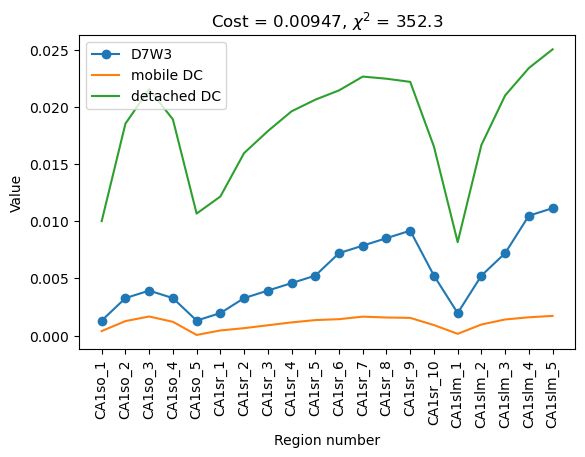

In [68]:
x=np.array(range(expD.shape[0]),dtype=int)
fig, ax = plt.subplots()
ax.plot(x,target,'o-',label=cname7)
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
ax.plot(x,resM,label='mobile DC')
ax.plot(x,resF,label='detached DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend(loc='upper left')
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_3w_202406161015best.png')
plt.savefig('bestFitEdita_20reg_1dv_3w_202406161015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_3w_202406161015best.svg')


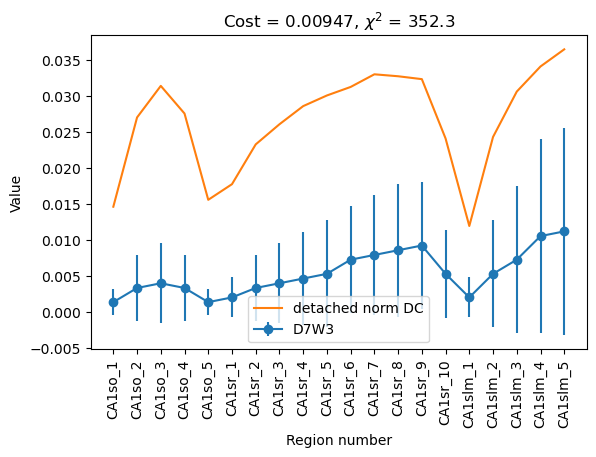

In [69]:
fig, ax = plt.subplots()
ax.errorbar(x,target,targSD,label=cname7, fmt='-o')
#ax.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='detached norm DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_3w_de_202406161015best.png')
plt.savefig('bestFitEdita_20reg_1dv_3w_de_202406161015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_3w_de_202406161015best.svg')


In [70]:
def calcUtrace3par(par,delta=bgSignal):
    F = bpar[0]
    Ctau = 10 ** par[0]
    mProp = bpar[2]
    dvA = par[1]
    dvB = par[2]
    dv = np.zeros(N)
    utarg = delta*np.ones(N)
    for k in range(N):
        if itarg[k] > 4:
            utarg[k] = bpar[itarg[k]]
            dv[k] = (10 ** dvA) + (10 ** dvB)*utarg[k]
    utarg /= np.sum(utarg)
    K = np.sum(utarg) / N
    x = trafficking_solution(F * utarg + (1 - F) * K)
    a = (1 / (1 + x))
    a = list(a)
    b = list((1 / (1 + x ** -1)))
    l = list(dv)
    c = list(Ctau * utarg / (F * utarg + (1 - F) * K))
    d = list(np.zeros(N))
    A = sushi_system(a, b, c, d, l)
    u0 = np.concatenate((mProp * dinit, (1 - mProp) * dinit))
    utrace = sim_time(A, u0, day7)
    return utrace

#par = [-16.81120695082292,-5.304089695904444,-12.387273346439557]
#cost = 3.6963521403227104
#par = [-6.146053650006426,-5.284385195872606,-18.0]
#cost = 1.4121248688210135
#par = [-5.613771283822604,-5.2215439090716185,-18.0]
#cost = 0.9900881157516854
par = [-5.591517353999318,-5.266710638487275,-17.999895594052166]
cost = 4.5368536883995205e-05
mProp = bpar[2]
utrace = calcUtrace3par(par)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)
resF_3par = resF

In [71]:
{'Ctau' : 10 ** par[0],
'dvA': 10 ** par[1],
'dvB': 10 ** par[2],
'T1/2': np.log(2)*7/((10 ** par[1]) * day7),
'sum_nobsDnn' : np.sum(nobsDnn),
'sum_nobsDnn^2' : np.sum(nobsDnn ** 2),
'sum_resM' : np.sum(resM),
'sum_resF' : np.sum(resF),
'sum_tot' : np.sum(resF)+np.sum(resM),
'err' : np.sum((resF/(1-mProp) - target) ** 2),
'err_norm' : np.sum((resF/(1-mProp) - target) ** 2)/tnorm,
'chi2' : np.sum(((resF/(1-mProp) - target)/targSD) ** 2),
'cost' : cost
}

{'Ctau': 2.5614309096712185e-06,
 'dvA': 5.4111473652332775e-06,
 'dvB': 1.0002404324783585e-18,
 'T1/2': 1.4825944056858167,
 'sum_nobsDnn': 0.5316133720994574,
 'sum_nobsDnn^2': 0.014889937339966802,
 'sum_resM': 0.06638467712065058,
 'sum_resF': 0.07511565687709212,
 'sum_tot': 0.1415003339977427,
 'err': 4.5368536883995205e-05,
 'err_norm': 0.06182331386691654,
 'chi2': 1.6428848371940945,
 'cost': 4.5368536883995205e-05}

In [72]:
dvA = par[1]
dvB = par[2]
dv = (10 ** dvA) + (10 ** dvB)*np.array(bpar[5:])
(expD.shape,expD['Abbreviation'],bpar[5:],dv,np.log(2)*7/(np.array(dv * day7)))

((20, 14),
 0      CA1so_1
 1      CA1so_2
 2      CA1so_3
 3      CA1so_4
 4      CA1so_5
 5      CA1sr_1
 6      CA1sr_2
 7      CA1sr_3
 8      CA1sr_4
 9      CA1sr_5
 10     CA1sr_6
 11     CA1sr_7
 12     CA1sr_8
 13     CA1sr_9
 14    CA1sr_10
 15    CA1slm_1
 16    CA1slm_2
 17    CA1slm_3
 18    CA1slm_4
 19    CA1slm_5
 Name: Abbreviation, dtype: object,
 [0.21382364663804718,
  0.06074280874523973,
  0.04781382417616123,
  0.04562340830020193,
  1.0000000000039887e-07,
  0.7733439929081787,
  0.5543045057407645,
  0.1468913931288651,
  0.14710118884157364,
  0.1316203146580693,
  0.15499357159791044,
  0.17296720163305693,
  0.20287137824434023,
  0.3735878952746845,
  0.5243019440900127,
  0.043864102155039865,
  0.1966480252602025,
  0.19591970216660096,
  0.2755074889018492,
  0.9999999999999992],
 array([5.41114737e-06, 5.41114737e-06, 5.41114737e-06, 5.41114737e-06,
        5.41114737e-06, 5.41114737e-06, 5.41114737e-06, 5.41114737e-06,
        5.41114737e-06, 5.4111473

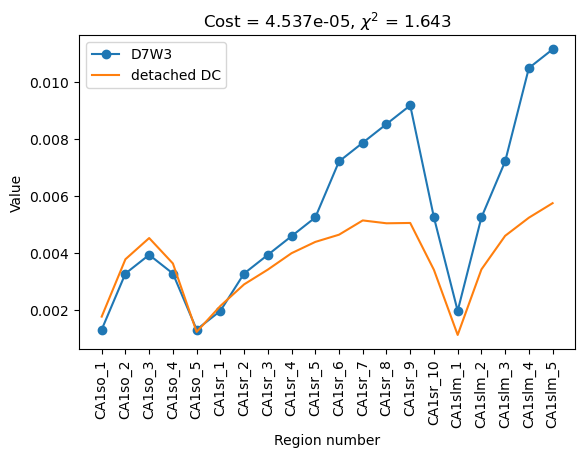

In [73]:
x=np.array(range(expD.shape[0]),dtype=int)
fig, ax = plt.subplots()

ax.plot(x,target,'o-',label=cname7)
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
#ax.plot(x,resM,label='mobile DC')
ax.plot(x,resF,label='detached DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_fit3w_3par_202406191015best.png')
plt.savefig('bestFitEdita_20reg_1dv_fit3w_3par_202406191015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_fit3w_3par_202406191015best.svg')


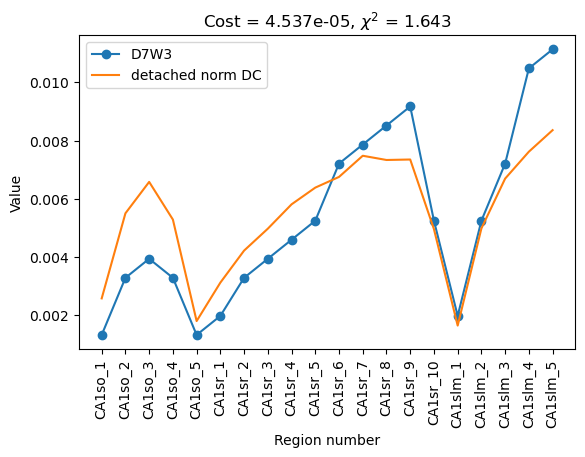

In [74]:
fig, ax = plt.subplots()
ax.plot(x,target,'o-',label=cname7)
#plt.errorbar(x,target,targSD,label=cname7, fmt='-o')
#ax.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='detached norm DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_fit3w_3par_de_202406191015best.png')
plt.savefig('bestFitEdita_20reg_1dv_fit3w_3par_de_202406191015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_fit3w_3par_de_202406191015best.svg')


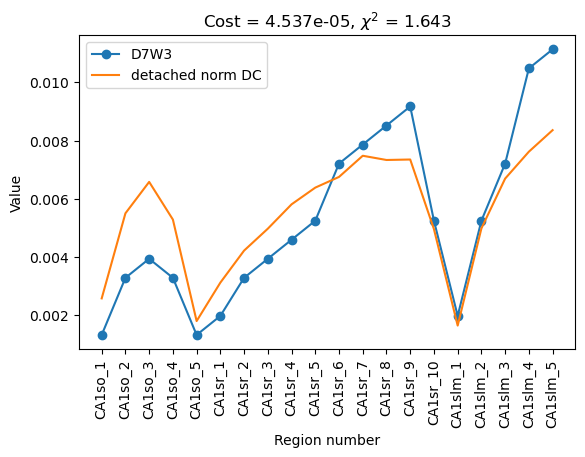

In [75]:
fig, ax = plt.subplots()
ax.plot(x,target,'o-',label=cname7)
#plt.errorbar(x,target,targSD,label=cname7, fmt='-o')
#plt.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='detached norm DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_fit3w_3par_deO_202406191015best.png')
plt.savefig('bestFitEdita_20reg_1dv_fit3w_3par_deO_202406191015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_fit3w_3par_deO_202406191015best.svg')


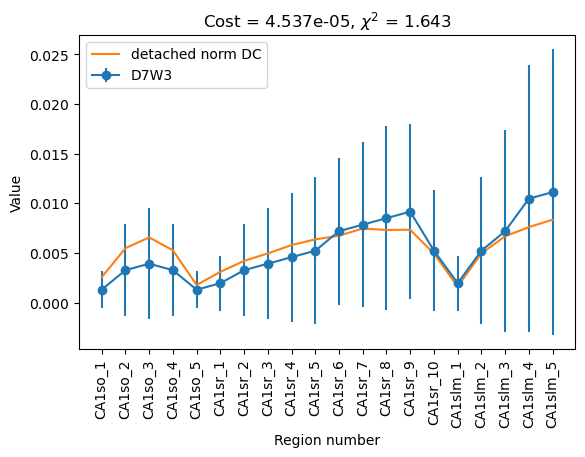

In [76]:
fig, ax = plt.subplots()
#plt.plot(x,target,label=cname7)
ax.errorbar(x,target,targSD,label=cname7, fmt='-o')
#plt.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='detached norm DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend(loc='upper left')
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_fit3w_3par_deE_202406191015best.png')
plt.savefig('bestFitEdita_20reg_1dv_fit3w_3par_deE_202406191015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_fit3w_3par_deE_202406191015best.svg')


In [77]:
def calcUtrace2par(par,delta=bgSignal):
    F = bpar[0]
    Ctau = 10 ** bpar[1]
    mProp = bpar[2]
    dvA = par[0]
    dvB = par[1]
    dv = np.zeros(N)
    utarg = delta*np.ones(N)
    for k in range(N):
        if itarg[k] > 4:
            utarg[k] = bpar[itarg[k]]
            dv[k] = (10 ** dvA) + (10 ** dvB)*utarg[k]
    utarg /= np.sum(utarg)
    K = np.sum(utarg) / N
    x = trafficking_solution(F * utarg + (1 - F) * K)
    a = (1 / (1 + x))
    a = list(a)
    b = list((1 / (1 + x ** -1)))
    l = list(dv)
    c = list(Ctau * utarg / (F * utarg + (1 - F) * K))
    d = list(np.zeros(N))
    A = sushi_system(a, b, c, d, l)
    u0 = np.concatenate((mProp * dinit, (1 - mProp) * dinit))
    utrace = sim_time(A, u0, day7)
    return utrace

par = [-5.283019429412654,-18.0]
cost = 4.872024346150998e-05
mProp = bpar[2]
utrace = calcUtrace2par(par)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)
resF_2par = resF

In [78]:
{'dvA': 10 ** par[0],
'dvB': 10 ** par[1],
'T1/2': np.log(2)*7/(10 ** par[0] * day7),
'sum_nobsDnn' : np.sum(nobsDnn),
'sum_nobsDnn^2' : np.sum(nobsDnn ** 2),
'sum_resM' : np.sum(resM),
'sum_resF' : np.sum(resF),
'sum_tot' : np.sum(resF)+np.sum(resM),
'err' : np.sum((resF/(1-mProp) - target) ** 2),
'err_norm' : np.sum((resF/(1-mProp) - target) ** 2)/tnorm,
'chi2' : np.sum(((resF/(1-mProp) - target)/targSD) ** 2),
'cost' : cost
}

{'dvA': 5.211713944823247e-06,
 'dvB': 1e-18,
 'T1/2': 1.539327924934392,
 'sum_nobsDnn': 0.5316133720994574,
 'sum_nobsDnn^2': 0.014889937339966802,
 'sum_resM': 0.022055150880798634,
 'sum_resF': 0.07542595358212834,
 'sum_tot': 0.09748110446292697,
 'err': 4.872024346150998e-05,
 'err_norm': 0.06639065550857755,
 'chi2': 1.8605165422045218,
 'cost': 4.872024346150998e-05}

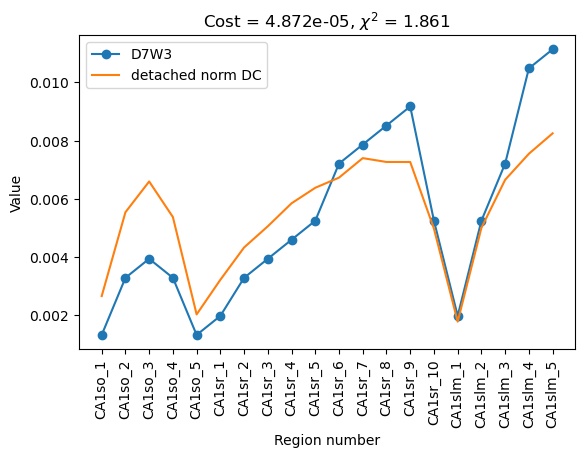

In [79]:
fig, ax = plt.subplots()
ax.plot(x,target,'o-',label=cname7)
#plt.errorbar(x,target,targSD,label=cname7, fmt='-o')
#ax.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='detached norm DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_fit3w_2par_de_202410300900best.png')
plt.savefig('bestFitEdita_20reg_1dv_fit3w_2par_de_202410300900best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_fit3w_2par_de_202410300900best.svg')


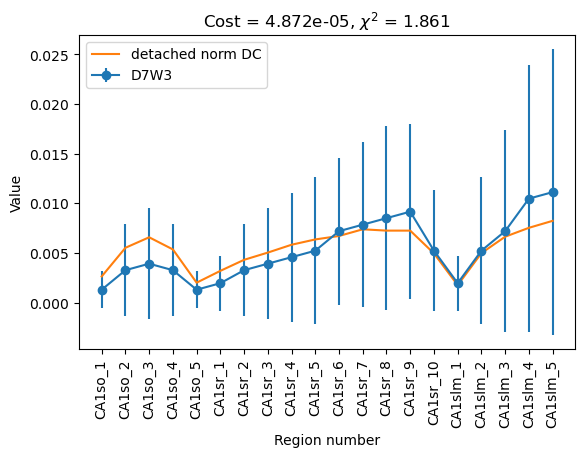

In [80]:
fig, ax = plt.subplots()
#plt.plot(x,target,label=cname7)
ax.errorbar(x,target,targSD,label=cname7, fmt='-o')
#plt.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='detached norm DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend(loc='upper left')
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_fit3w_2par_deE_202410300900best.png')
plt.savefig('bestFitEdita_20reg_1dv_fit3w_2par_deE_202410300900best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_fit3w_2par_deE_202410300900best.svg')


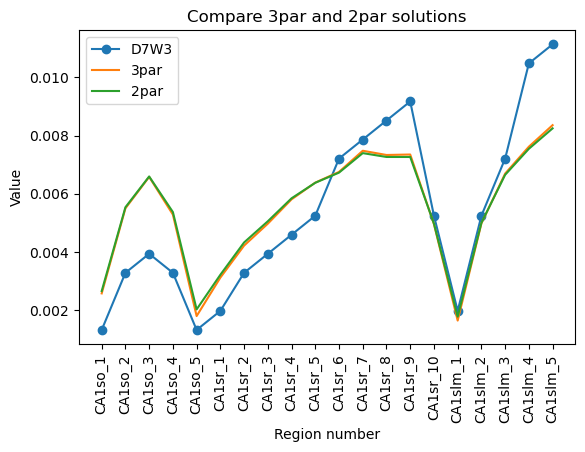

In [81]:
fig, ax = plt.subplots()
ax.plot(x,target,'o-',label=cname7)
#plt.errorbar(x,target,targSD,label=cname7, fmt='-o')
#ax.plot(x,resF,label='detached DC')
ax.plot(x,resF_3par/(1-mProp),label='3par')
ax.plot(x,resF_2par/(1-mProp),label='2par')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Compare 3par and 2par solutions") 
# function to show the plot
plt.show()


Day 0 18 month
----

In [82]:
bgSignal = 1e-5
cname0='D0M318'
d0w = -1 * np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d0w[sidx] *= -1*expD[f"{cname0}_MEAN"][i]/len(sidx)
for i in range(N):
    if d0w[i]<0:
        d0w[i] = bgSignal
dinit = d0w/np.sum(d0w)

cname7='D7M318'
d7w = -1*np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d7w[sidx] *= -1 * expD[f"{cname7}_MEAN"][i]/len(sidx)
for i in range(N):
    if d7w[i]<0:
        d7w[i] = bgSignal
target = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]) #norm target to Day0 sum to take into accound degradation
targSD = np.array(expD[f"{cname7}_SD"])/np.sum(expD[f"{cname0}_MEAN"]) #measurement errors
tnorm = np.sum(target ** 2)
day7 = 7 * 24 * 3600 # final time point

itarg = np.ones(N, dtype=int)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx = segIdx[abb]
    itarg[sidx] *= (i+5)

#par = [0.111784701917933,-1,0.584647952749801,-5.40926182202759,-7.58373647291078,0.93075347720533,0.150119155946245,0.250026616923097,0.247923892623914,1,0.829698078092076,0.799680386796054,0.435204401984173,0.776990953492751,0.658564397472255,0.669466722069782,0.13217494651507,0.452337127435389,0.818398235362628,0.287266237055001,0.693374804035749,0.387600533946115,0.860396244028168,0.793857689742176,0.00234423876609767]
#cost=0.2289827
#par = [0.141527769926587,-1.04440055844237,0.381706990604462,-5.43766625150405,-12.234744035647,1,0.164098437336494,0.272405308568442,0.427804635567134,0.812746641751752,0.919149761897559,0.672064846552212,0.149965791068772,0.539839422213906,0.812188937409397,0.806685239524521,0.165041822978698,0.529423937850048,0.828384035574742,0.221525313745652,0.676304529167494,0.634182580029409,0.814899037032692,0.790009814378913,0.0884319910464033]
#cost=0.1914477
#par = [1.0,-18.0,0.339665263904274,-18.0,-0.1056091212860899,1.0,0.06274608035463802,4.4574543322602384e-07,0.02193672327975435,0.0870196802604857,8.738149616920519e-07,1.0,0.23641992030781905,0.20499095398769174,3.3139951083305927e-07,0.0264354594647535,1.0601425384202188e-07,0.018642526550405554,1.3229426155908984e-07,0.321659768251798,1.256853193752937e-06,0.9999991575763989,0.9008918582308576,1.0002936595814933e-07,1.0]
#cost = 0.00972634
#par = [0.18124010722657255,-18.0,0.4770849437408547,-18.0,-7.528208406834074,0.6335729107600226,0.28276999275111847,0.558910113544302,1.0,0.3929830308454687,0.2992123958197709,0.753091076326252,1.0,0.17238067898531845,1.0,1e-07,1.0,0.04290036974800929,0.9692956552909402,1.0,0.5346212757781438,1.0,0.28625682786833306,1e-07,1e-07]
#cost = 0.02659
#par = [0.32023059450279123,-6.327308855004608,0.627385538130974,-18.0,-17.999431588729976,0.06854654347167044,0.060486839296889444,0.04484900714349323,0.03490854158366522,0.00024252729610862994,0.32943753444660906,0.4029203029951907,0.12801603593190886,0.14871930210853104,0.14171491277653797,0.18024101228415457,0.18628112282529372,0.23357327869041905,0.4302044118823936,0.5008667022509936,0.0038157043176590766,0.2007104314288199,0.22494314014617123,0.31189759389623783,0.9999999999990268]
#cost = 0.001142
#par = [0.01385481065982917,-6.226265838840085,0.6709771115511489,-17.995913305482574,-16.696101588995024,0.21868548101204954,0.06211405206769383,0.048882353452234434,0.046632773486508856,1.9401449712242143e-06,0.7864443640945032,0.5632548318074286,0.14915702983161863,0.1491589398028194,0.13322800132469398,0.15668388533325328,0.17435550169553826,0.20436446923690443,0.37541096611836217,0.5260391371129066,0.043995168941356404,0.1970021740399707,0.19622524557390722,0.2758337024352678,0.9999999999613025]
#cost = 1.51e-09
par = [0.8861278052764772,-5.358123919558814,0.3127455791698551,-5.7356821635860165,-17.999032750284783,0.21382364663804718,0.06074280874523973,0.04781382417616123,0.04562340830020193,1.0000000000039887e-07,0.7733439929081787,0.5543045057407645,0.1468913931288651,0.14710118884157364,0.1316203146580693,0.15499357159791044,0.17296720163305693,0.20287137824434023,0.3735878952746845,0.5243019440900127,0.043864102155039865,0.1966480252602025,0.19591970216660096,0.2755074889018492,0.9999999999999992]
cost = 3.331839554992909e-11
mProp = par[2]
utrace = calcUtrace(par)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)


In [83]:
np.array(par)-np.array(bpar)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [84]:
{'F' : par[0],
'Ctau' : 10 ** par[1],
'mProp' : par[2],
'dvA': 10 ** par[3],
'dvB': 10 ** par[4],
'demand_CA1so_1' : par[5],
'demand_CA1so_2' : par[6],
'demand_CA1so_3' : par[7],
'demand_CA1so_4' : par[8],
'demand_CA1so_5' : par[9],
'demand_CA1sr_1' : par[10],
'demand_CA1sr_2' : par[11],
'demand_CA1sr_3' : par[12],
'demand_CA1sr_4' : par[13],
'demand_CA1sr_5' : par[14],
'demand_CA1sr_6' : par[15],
'demand_CA1sr_7' : par[16],
'demand_CA1sr_8' : par[17],
'demand_CA1sr_9' : par[18],
'demand_CA1sr_10' : par[19],
'demand_CA1slm_1' : par[20],
'demand_CA1slm_2' : par[21],
'demand_CA1slm_3' : par[22],
'demand_CA1slm_4' : par[23],
'demand_CA1slm_5' : par[24],
'sum_nobsDnn' : np.sum(nobsDnn),
'sum_nobsDnn^2' : np.sum(nobsDnn ** 2),
'sum_resM' : np.sum(resM),
'sum_resF' : np.sum(resF),
'sum_tot' : np.sum(resF)+np.sum(resM),
'err' : np.sum((resF/(1-mProp) - target) ** 2),
'err_norm' : np.sum((resF/(1-mProp) - target) ** 2)/tnorm,
'chi2' : np.sum(((resF/(1-mProp) - target)/targSD) ** 2),
'cost' : cost
}

{'F': 0.8861278052764772,
 'Ctau': 4.384055873241875e-06,
 'mProp': 0.3127455791698551,
 'dvA': 1.8378828974092036e-06,
 'dvB': 1.0022296567714719e-18,
 'demand_CA1so_1': 0.21382364663804718,
 'demand_CA1so_2': 0.06074280874523973,
 'demand_CA1so_3': 0.04781382417616123,
 'demand_CA1so_4': 0.04562340830020193,
 'demand_CA1so_5': 1.0000000000039887e-07,
 'demand_CA1sr_1': 0.7733439929081787,
 'demand_CA1sr_2': 0.5543045057407645,
 'demand_CA1sr_3': 0.1468913931288651,
 'demand_CA1sr_4': 0.14710118884157364,
 'demand_CA1sr_5': 0.1316203146580693,
 'demand_CA1sr_6': 0.15499357159791044,
 'demand_CA1sr_7': 0.17296720163305693,
 'demand_CA1sr_8': 0.20287137824434023,
 'demand_CA1sr_9': 0.3735878952746845,
 'demand_CA1sr_10': 0.5243019440900127,
 'demand_CA1slm_1': 0.043864102155039865,
 'demand_CA1slm_2': 0.1966480252602025,
 'demand_CA1slm_3': 0.19591970216660096,
 'demand_CA1slm_4': 0.2755074889018492,
 'demand_CA1slm_5': 0.9999999999999992,
 'sum_nobsDnn': 0.5316133720994574,
 'sum_nobsD

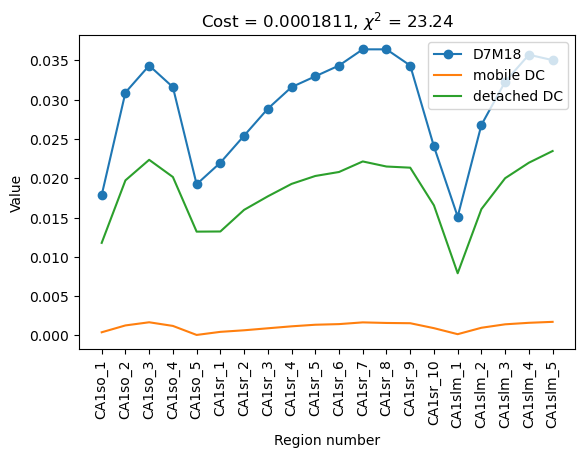

In [85]:
x=np.array(range(expD.shape[0]),dtype=int)
fig, ax = plt.subplots()

ax.plot(x,target,'o-',label='D7M18')
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
ax.plot(x,resM,label='mobile DC')
ax.plot(x,resF,label='detached DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_18m_202406161015best.png')
plt.savefig('bestFitEdita_20reg_1dv_18m_202406161015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_18m_202406161015best.svg')


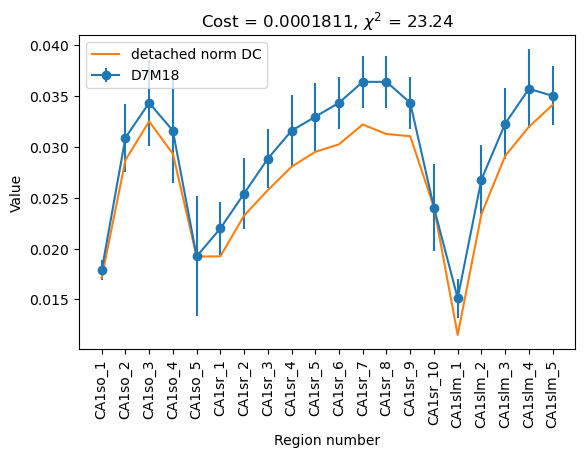

In [86]:
fig, ax = plt.subplots()
ax.errorbar(x,target,targSD,label='D7M18', fmt='-o')
#ax.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='detached norm DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_18m_de_202406161015best.png')
plt.savefig('bestFitEdita_20reg_1dv_18m_de_202406161015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_18m_de_202406161015best.svg')


In [87]:
def calcUtrace3par(par,delta=bgSignal):
    F = bpar[0]
    Ctau = 10 ** par[0]
    mProp = bpar[2]
    dvA = par[1]
    dvB = par[2]
    dv = np.zeros(N)
    utarg = delta*np.ones(N)
    for k in range(N):
        if itarg[k] > 4:
            utarg[k] = bpar[itarg[k]]
            dv[k] = (10 ** dvA) + (10 ** dvB)*utarg[k]
    utarg /= np.sum(utarg)
    K = np.sum(utarg) / N
    x = trafficking_solution(F * utarg + (1 - F) * K)
    a = (1 / (1 + x))
    a = list(a)
    b = list((1 / (1 + x ** -1)))
    l = list(dv)
    c = list(Ctau * utarg / (F * utarg + (1 - F) * K))
    d = list(np.zeros(N))
    A = sushi_system(a, b, c, d, l)
    u0 = np.concatenate((mProp * dinit, (1 - mProp) * dinit))
    utrace = sim_time(A, u0, day7)
    return utrace

#par = [-16.81120695082292,-5.304089695904444,-12.387273346439557]
#cost = 3.6963521403227104
#par = [-5.35361070901644,-5.781162290769705,-18.0]
#cost = 5.427795967245935
par = [-5.3473724799433935,-5.7875758356325395,-7.0200863650857634]
cost = 3.359950648864551e-05
mProp = bpar[2]
utrace = calcUtrace3par(par)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)
resF_3par = resF

In [88]:
{'Ctau' : 10 ** par[0],
'dvA': 10 ** par[1],
'dvB': 10 ** par[2],
'sum_nobsDnn' : np.sum(nobsDnn),
'sum_nobsDnn^2' : np.sum(nobsDnn ** 2),
'sum_resM' : np.sum(resM),
'sum_resF' : np.sum(resF),
'sum_tot' : np.sum(resF)+np.sum(resM),
'err' : np.sum((resF/(1-mProp) - target) ** 2),
'err_norm' : np.sum((resF/(1-mProp) - target) ** 2)/tnorm,
'chi2' : np.sum(((resF/(1-mProp) - target)/targSD) ** 2),
'cost' : cost
}

{'Ctau': 4.493942590401466e-06,
 'dvA': 1.6308881019486249e-06,
 'dvB': 9.548026922519684e-08,
 'sum_nobsDnn': 0.5316133720994574,
 'sum_nobsDnn^2': 0.014889937339966802,
 'sum_resM': 0.02064125394800149,
 'sum_resF': 0.40167487778761174,
 'sum_tot': 0.4223161317356132,
 'err': 3.359950648864551e-05,
 'err_norm': 0.0018724711720005142,
 'chi2': 4.912518081257999,
 'cost': 3.359950648864551e-05}

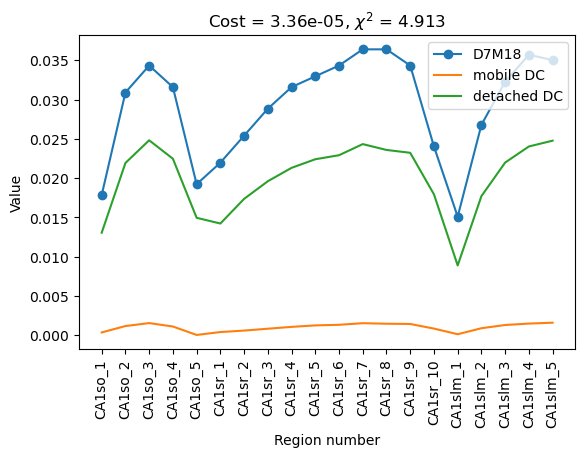

In [89]:
x=np.array(range(expD.shape[0]),dtype=int)
fig, ax = plt.subplots()

ax.plot(x,target,'o-',label='D7M18')
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
ax.plot(x,resM,label='mobile DC')
ax.plot(x,resF,label='detached DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_fit18m_3par_202406191015best.png')
plt.savefig('bestFitEdita_20reg_1dv_fit18m_3par_202406191015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_fit18m_3par_202406191015best.svg')


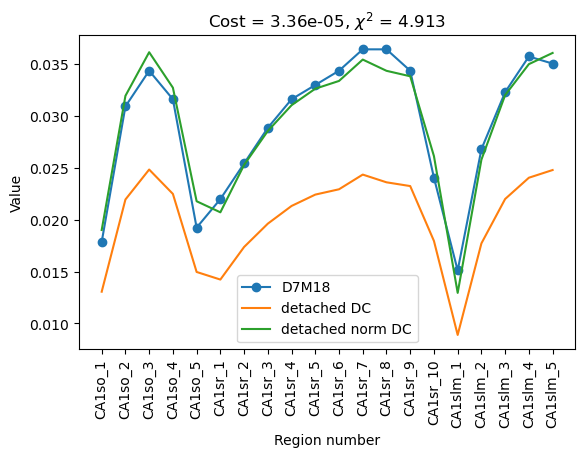

In [90]:
fig, ax = plt.subplots()
ax.plot(x,target,'o-',label='D7M18')
ax.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='detached norm DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_fit18m_3par_de_202406191015best.png')
plt.savefig('bestFitEdita_20reg_1dv_fit18m_3par_de_202406191015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_fit18m_3par_de_202406191015best.svg')


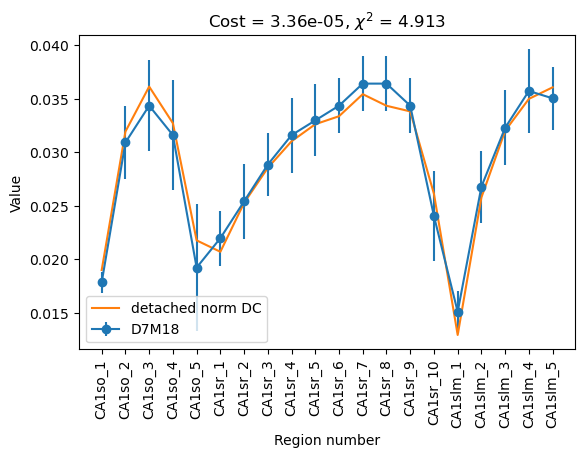

In [91]:
fig, ax = plt.subplots()
ax.errorbar(x,target,targSD,label='D7M18', fmt='-o')
#ax.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='detached norm DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_fit18m_3par_de_202406191015best.png')
plt.savefig('bestFitEdita_20reg_1dv_fit18m_3par_de_202406191015best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_fit18m_3par_de_202406191015best.svg')


In [92]:
len(par)

3

In [93]:
def calcUtrace2par(par,delta=bgSignal):
    F = bpar[0]
    Ctau = 10 ** bpar[1]
    mProp = bpar[2]
    dvA = par[0]
    dvB = par[1]
    dv = np.zeros(N)
    utarg = delta*np.ones(N)
    for k in range(N):
        if itarg[k] > 4:
            utarg[k] = bpar[itarg[k]]
            dv[k] = (10 ** dvA) + (10 ** dvB)*utarg[k]
    utarg /= np.sum(utarg)
    K = np.sum(utarg) / N
    x = trafficking_solution(F * utarg + (1 - F) * K)
    a = (1 / (1 + x))
    a = list(a)
    b = list((1 / (1 + x ** -1)))
    l = list(dv)
    c = list(Ctau * utarg / (F * utarg + (1 - F) * K))
    d = list(np.zeros(N))
    A = sushi_system(a, b, c, d, l)
    u0 = np.concatenate((mProp * dinit, (1 - mProp) * dinit))
    utrace = sim_time(A, u0, day7)
    return utrace

par = [-5.78767290580479,-7.018887371451555]
cost = 3.36090308526812e-05
mProp = bpar[2]
utrace = calcUtrace2par(par)
resM, resF = sushibelt.aggregate_segments(utrace[:, -1], segIdx, expD['Abbreviation'], fun=np.sum)
resF_2par = resF

In [94]:
{'dvA': 10 ** par[0],
'dvB': 10 ** par[1],
'T1/2': np.log(2)*7/(10 ** par[0] * day7),
'sum_nobsDnn' : np.sum(nobsDnn),
'sum_nobsDnn^2' : np.sum(nobsDnn ** 2),
'sum_resM' : np.sum(resM),
'sum_resF' : np.sum(resF),
'sum_tot' : np.sum(resF)+np.sum(resM),
'err' : np.sum((resF/(1-mProp) - target) ** 2),
'err_norm' : np.sum((resF/(1-mProp) - target) ** 2)/tnorm,
'chi2' : np.sum(((resF/(1-mProp) - target)/targSD) ** 2),
'cost' : cost
}

{'dvA': 1.6305236190811076e-06,
 'dvB': 9.574423391493591e-08,
 'T1/2': 4.92022115972632,
 'sum_nobsDnn': 0.5316133720994574,
 'sum_nobsDnn^2': 0.014889937339966802,
 'sum_resM': 0.022058931706773963,
 'sum_resF': 0.4016721111862242,
 'sum_tot': 0.4237310428929982,
 'err': 3.36090308526812e-05,
 'err_norm': 0.001873001956495652,
 'chi2': 4.9120052724994006,
 'cost': 3.36090308526812e-05}

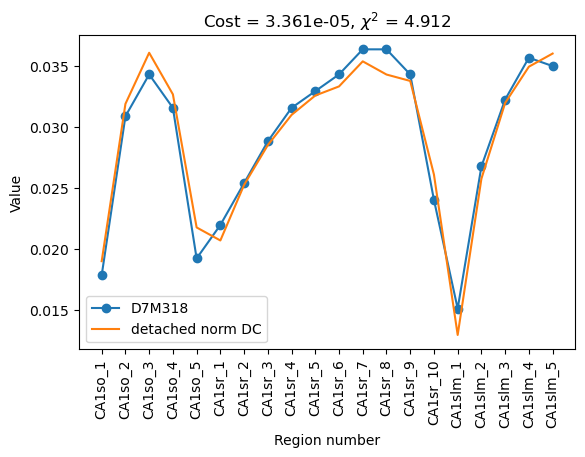

In [95]:
fig, ax = plt.subplots()
ax.plot(x,target,'o-',label=cname7)
#plt.errorbar(x,target,targSD,label=cname7, fmt='-o')
#ax.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='detached norm DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_fit18M_2par_de_20241031best.png')
plt.savefig('bestFitEdita_20reg_1dv_fit18M_2par_de_20241031best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_fit18M_2par_de_20241031best.svg')


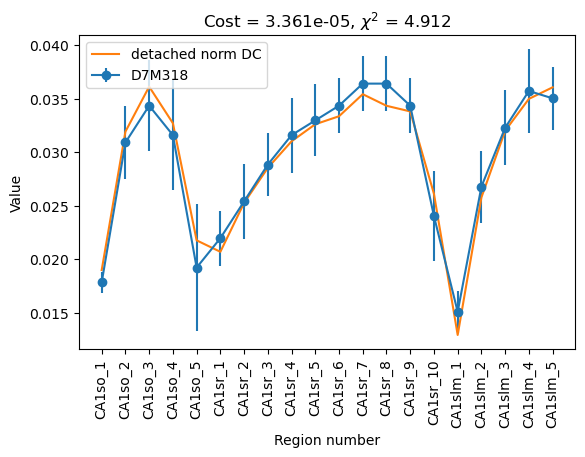

In [96]:
fig, ax = plt.subplots()
#plt.plot(x,target,label=cname7)
ax.errorbar(x,target,targSD,label=cname7, fmt='-o')
#plt.plot(x,resF,label='detached DC')
ax.plot(x,resF/(1-mProp),label='detached norm DC')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend(loc='upper left')
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Cost = {format(np.sum((resF/(1-mProp) - target) ** 2),'.4g')}, $\chi^2$ = {format(np.sum(((resF/(1-mProp) - target)/targSD) ** 2),'.4g')}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_fit18M_2par_deE_20241031best.png')
plt.savefig('bestFitEdita_20reg_1dv_fit18M_2par_deE_20241031best.pdf')
plt.savefig('bestFitEdita_20reg_1dv_fit18M_2par_deE_20241031best.svg')


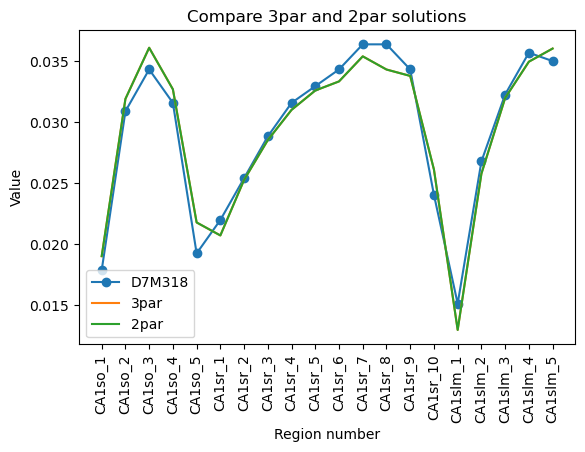

In [97]:
fig, ax = plt.subplots()
ax.plot(x,target,'o-',label=cname7)
#plt.errorbar(x,target,targSD,label=cname7, fmt='-o')
#ax.plot(x,resF,label='detached DC')
ax.plot(x,resF_3par/(1-mProp),label='3par')
ax.plot(x,resF_2par/(1-mProp),label='2par')
ax.set_xlabel('Region number')
ax.set_ylabel('Value')
ax.set_xticks(x,expD['Abbreviation'],rotation=90)
# show a legend on the plot
ax.legend()
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width , pos.height* 0.85])
plt.title(f"Compare 3par and 2par solutions") 
# function to show the plot
plt.show()


In [98]:
dvA=np.array([1.8378828974092036e-06,5.4111473652332775e-06,1.6308881019486249e-06])
np.log(2)*7/(dvA * day7)

array([4.36509683, 1.48259441, 4.91912155])